# Prediccion de ratings de jugadores por partido

Utilizaremos los datos de statsbomb con los controles orientados

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsbombpy import sb
from datetime import datetime
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error


In [2]:
# Import the data
df_sub_events = pd.read_csv('sub_action_eur_masc_2024.csv')
df_secuencias = pd.read_csv('secuencias_eur_masc_2024.csv')
df_ratings = pd.read_csv('sportmonks_player_ratings_euro_masc_2024.csv')

C:\Users\antonio\AppData\Local\Temp\ipykernel_14652\2808859537.py:2: DtypeWarning: Columns (0,1,3,4,16,17,18,19,21,26,31,43,44,46,50,56,68,70,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sub_events = pd.read_csv('sub_action_eur_masc_2024.csv')


In [3]:
df_ratings.head()

,match_id,match_date,player_id,player_name,team_id,team_name,player_rating,player_minutes
0,19032613,2024-06-14 19:00:00,30642,Manuel Neuer,18660,Germany,6.09,90
1,19032613,2024-06-14 19:00:00,31837,Antonio Rüdiger,18660,Germany,6.42,90
2,19032613,2024-06-14 19:00:00,31836,Jonathan Tah,18660,Germany,6.63,90
3,19032613,2024-06-14 19:00:00,31504,Pascal Groß,18660,Germany,6.50,44
4,19032613,2024-06-14 19:00:00,32362,Joshua Kimmich,18660,Germany,7.53,90


In [4]:
df_ratings['team_name'].unique()

array(['Germany', 'Scotland', 'Switzerland', 'Hungary', 'Croatia',
       'Spain', 'Albania', 'Italy', 'Netherlands', 'Poland', 'Denmark',
       'Slovenia', 'England', 'Serbia', 'Ukraine', 'Romania', 'Slovakia',
       'Belgium', 'Austria', 'France', 'Georgia', 'Turkey', 'Portugal',
       'Czech Republic'], dtype=object)

In [5]:
eur_24_matches = sb.matches(competition_id=55, season_id=282)
eur_24_matches.head()

c:\Users\antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3942819,2024-07-10,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,England,1,2,available,...,2024-07-15T07:57:36.684453,6,Semi-finals,Signal-Iduna-Park,Felix Zwayer,Ronald Koeman,Gareth Southgate,1.1.0,2,2
1,3943043,2024-07-14,22:00:00.000,Europe - UEFA Euro,2024,Spain,England,2,1,available,...,2024-07-15T15:52:24.778809,7,Final,Olympiastadion Berlin,François Letexier,Luis de la Fuente Castillo,Gareth Southgate,1.1.0,2,2
2,3942752,2024-07-09,22:00:00.000,Europe - UEFA Euro,2024,Spain,France,2,1,available,...,2024-07-10T13:01:26.597509,6,Semi-finals,Allianz Arena,Slavko Vinčić,Luis de la Fuente Castillo,Didier Deschamps,1.1.0,2,2
3,3942382,2024-07-06,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,Turkey,2,1,available,...,2024-07-10T06:56:35.146850,5,Quarter-finals,Olympiastadion Berlin,Clément Turpin,Ronald Koeman,Vincenzo Montella,1.1.0,2,2
4,3942349,2024-07-05,22:00:00.000,Europe - UEFA Euro,2024,Portugal,France,0,0,available,...,2024-07-12T02:00:16.871522,5,Quarter-finals,Volksparkstadion,Michael Oliver,Roberto Martínez Montoliú,Didier Deschamps,1.1.0,2,2


In [6]:
eur_24_matches['match_id'].unique()

array([3942819, 3943043, 3942752, 3942382, 3942349, 3930180, 3930171,
       3942227, 3942226, 3938645, 3930184, 3941022, 3941021, 3941020,
       3941019, 3941018, 3941017, 3930182, 3930179, 3940983, 3940878,
       3930177, 3930173, 3930172, 3930167, 3930168, 3930165, 3930164,
       3930161, 3938637, 3938640, 3938642, 3938639, 3938641, 3938644,
       3938643, 3938638, 3930183, 3930181, 3930178, 3930176, 3930175,
       3930174, 3930170, 3930169, 3930166, 3930163, 3930162, 3930160,
       3930159, 3930158])

In [9]:
print(eur_24_matches['match_date'].dtype)
print(df_ratings['match_date'].dtype)

object
object


In [10]:
df_ratings['match_date'] = df_ratings['match_date'].str.split(' ').str[0]

In [11]:
df_ratings.head()

,match_id,match_date,player_id,player_name,team_id,team_name,player_rating,player_minutes
0,19032613,2024-06-14,30642,Manuel Neuer,18660,Germany,6.09,90
1,19032613,2024-06-14,31837,Antonio Rüdiger,18660,Germany,6.42,90
2,19032613,2024-06-14,31836,Jonathan Tah,18660,Germany,6.63,90
3,19032613,2024-06-14,31504,Pascal Groß,18660,Germany,6.50,44
4,19032613,2024-06-14,32362,Joshua Kimmich,18660,Germany,7.53,90


In [12]:
set(eur_24_matches['home_team'].unique()) - set(df_ratings['team_name'].unique())

set()

In [ ]:
# Juntamos los datos entre Statsbomb y Sportmonks empezando por los partidos
# Borramos los espacios en blanco en los nombres
df_ratings['team_name'] = df_ratings['team_name'].str.strip()
eur_24_matches['home_team'] = eur_24_matches['home_team'].str.strip()
eur_24_matches['away_team'] = eur_24_matches['away_team'].str.strip()

home_merge = pd.merge(
    eur_24_matches,
    df_ratings,
    left_on=['match_date', 'home_team'],
    right_on=['match_date', 'team_name'],
    suffixes=('_statsbomb', '_ratings')
)

away_merge = pd.merge(
    eur_24_matches,
    df_ratings,
    left_on=['match_date', 'away_team'],
    right_on=['match_date', 'team_name'],
    suffixes=('_statsbomb', '_ratings')
)

pairs_df = pd.concat([home_merge, away_merge], ignore_index=True)

pairs_df = pairs_df[['match_id_statsbomb', 'match_id_ratings', 'match_date', 'team_name']].drop_duplicates()

print("Number of matches in StatsBomb:", len(eur_24_matches))
print("Number of rows in merged pairs_df:", len(pairs_df))
print("Teams missing from pairs_df:", set(eur_24_matches['home_team']).union(set(eur_24_matches['away_team'])) - set(pairs_df['team_name']))

pairs_df.head()

Number of matches in StatsBomb: 51
Number of rows in merged pairs_df: 98
Teams missing from pairs_df: set()


,match_id_statsbomb,match_id_ratings,match_date,team_name
0,3942819,19032600,2024-07-10,Netherlands
13,3943043,19032598,2024-07-14,Spain
27,3942752,19032599,2024-07-09,Spain
41,3942382,19032603,2024-07-06,Netherlands
57,3942349,19032602,2024-07-05,Portugal


In [ ]:
# Partidos no pareados
all_teams = set(eur_24_matches['home_team']).union(set(eur_24_matches['away_team']))
paired_teams = set(pairs_df['team_name'])
print("Teams not paired:", all_teams - paired_teams)

Teams not paired: set()


In [ ]:
# Encontrar partidos faltantes
expected = pd.concat([
    eur_24_matches[['match_id', 'match_date', 'home_team']].rename(columns={'home_team': 'team_name'}),
    eur_24_matches[['match_id', 'match_date', 'away_team']].rename(columns={'away_team': 'team_name'})
], ignore_index=True)

merged = pd.merge(
    expected,
    pairs_df,
    left_on=['match_id', 'match_date', 'team_name'],
    right_on=['match_id_statsbomb', 'match_date', 'team_name'],
    how='left',
    indicator=True
)

missing = merged[merged['_merge'] == 'left_only']
print(missing[['match_id', 'match_date', 'team_name']])

    match_id  match_date team_name
9    3938645  2024-06-26   Ukraine
38   3930181  2024-06-25   England
60   3938645  2024-06-26   Belgium
89   3930181  2024-06-25  Slovenia


In [16]:
merged

,match_id,match_date,team_name,match_id_statsbomb,match_id_ratings,_merge
0,3942819,2024-07-10,Netherlands,3942819.0,19032600.0,both
1,3943043,2024-07-14,Spain,3943043.0,19032598.0,both
2,3942752,2024-07-09,Spain,3942752.0,19032599.0,both
3,3942382,2024-07-06,Netherlands,3942382.0,19032603.0,both
4,3942349,2024-07-05,Portugal,3942349.0,19032602.0,both
...,...,...,...,...,...,...
97,3930163,2024-06-16,England,3930163.0,19032623.0,both
98,3930162,2024-06-16,Denmark,3930162.0,19032622.0,both
99,3930160,2024-06-15,Croatia,3930160.0,19032616.0,both
100,3930159,2024-06-15,Switzerland,3930159.0,19045701.0,both


In [17]:
df_ratings['match_date'].dtypes
df_ratings['match_date'] = pd.to_datetime(df_ratings['match_date'], format='%Y-%m-%d')
pairs_df['match_date'] = pd.to_datetime(pairs_df['match_date'], format='%Y-%m-%d')

In [18]:
date = '2024-06-26'
date = pd.to_datetime(date)
# date = pd.Timestamp(2024, 7, 6)

In [19]:
df_ratings[(df_ratings['team_name'] == 'Ukraine') & (df_ratings['match_date'] == date)]

,match_id,match_date,player_id,player_name,team_id,team_name,player_rating,player_minutes


In [20]:
date = '2024-06-25'
date = pd.to_datetime(date)
# date = pd.Timestamp(2024, 7, 6)
df_ratings[(df_ratings['team_name'] == 'England') & (df_ratings['match_date'] == date)]

,match_id,match_date,player_id,player_name,team_id,team_name,player_rating,player_minutes


In [21]:
df_ratings[(df_ratings['team_name'] == 'Ukraine')]['match_date'].unique()

<DatetimeArray>
['2024-06-17 00:00:00', '2024-06-21 00:00:00']
Length: 2, dtype: datetime64[ns]

In [22]:
df_ratings[df_ratings['match_date'] == date]['team_name'].unique()

array(['Austria', 'Netherlands', 'France', 'Poland', 'Denmark', 'Serbia'],
      dtype=object)

Concluimos que los partidos entre Ucrania y Belgica e Inglaterra y Eslovenia no tienen datos de ratings. Por lo que tenemos en total 98 * 22 = 2156 filas de ratings de jugadores.

In [ ]:
# Juntar los resultados a ratings para añadir el id del partido de statsbomb
df_ratings_statsbomb = pd.merge(
    df_ratings,
    pairs_df[['match_id_statsbomb', 'match_id_ratings', 'team_name', 'match_date']],
    left_on=['match_id', 'team_name', 'match_date'],
    right_on=['match_id_ratings', 'team_name', 'match_date'],
    how='left'
)

df_ratings_statsbomb = df_ratings_statsbomb.drop(columns=['match_id_ratings'])
df_ratings_statsbomb

,match_id,match_date,player_id,player_name,team_id,team_name,player_rating,player_minutes,match_id_statsbomb
0,19032613,2024-06-14,30642,Manuel Neuer,18660,Germany,6.09,90,3930158
1,19032613,2024-06-14,31837,Antonio Rüdiger,18660,Germany,6.42,90,3930158
2,19032613,2024-06-14,31836,Jonathan Tah,18660,Germany,6.63,90,3930158
3,19032613,2024-06-14,31504,Pascal Groß,18660,Germany,6.50,44,3930158
4,19032613,2024-06-14,32362,Joshua Kimmich,18660,Germany,7.53,90,3930158
...,...,...,...,...,...,...,...,...,...
1504,19032598,2024-07-14,530762,Martín Zubimendi,18710,Spain,7.14,44,3943043
1505,19032598,2024-07-14,37656179,Lamine Yamal,18710,Spain,7.75,89,3943043
1506,19032598,2024-07-14,186932,Mikel Oyarzabal,18710,Spain,7.65,22,3943043
1507,19032598,2024-07-14,187215,Unai Simón,18710,Spain,6.63,90,3943043


In [24]:
df_sub_events['match_id'].nunique()

51

In [25]:
df_ratings_statsbomb['player_rating'].value_counts()

player_rating
6.83    39
6.94    36
6.63    31
7.04    29
6.73    25
        ..
9.83     1
8.47     1
8.19     1
5.71     1
8.26     1
Name: count, Length: 269, dtype: int64

Vamos a generar el dataframe final para la predicción, pero primero vamos a unir los jugadores del dataframe de ratings con el de statsbomb.

In [26]:
print(df_sub_events['player'].nunique())
print(df_sub_events['player_id'].nunique())
print(df_ratings_statsbomb['player_name'].nunique())

496
496
645


In [ ]:
# Jugadores unicos de ambos df
sub_events_players = set(df_sub_events['player'].dropna().unique())
ratings_players = set(df_ratings_statsbomb['player_name'].dropna().unique())

players_only_in_sub_events = sub_events_players - ratings_players

players_only_in_ratings = ratings_players - sub_events_players

print(f"Players in df_sub_events but not in df_ratings_statsbomb: {len(players_only_in_sub_events)}")
print(players_only_in_sub_events)
print(f"\nPlayers in df_ratings_statsbomb but not in df_sub_events: {len(players_only_in_ratings)}")
print(players_only_in_ratings)

Players in df_sub_events but not in df_ratings_statsbomb: 198
{'Jorge Luiz Frello Filho', 'Rafael Alexandre Conceição Leão', 'Unai Simón Mendibil', 'Dávid Hancko', 'Daniel Olmo Carvajal', 'László Kleinheisler', 'Matěj Kovář', 'Rasmus Winther Højlund', 'Adam Hložek', 'António João Pereira Albuquerque Tavares Silva', 'Lamine Yamal Nasraoui Ebana', 'Daniel Carvajal Ramos', 'Michał Skóraś', 'Joško Gvardiol', 'José Luis Sanmartín Mato', 'Breel-Donald Embolo', 'Alejandro Baena Rodríguez', 'Victor Bernth Kristansen', 'Timi Elšnik', 'Nélson Cabral Semedo', 'Fehmi Mert Günok', 'Theo Bernard François Hernández', 'Ferrán Torres García', 'Álvaro Borja Morata Martín', 'Bernardo Mota Veiga de Carvalho e Silva', 'Luka Ivanušec', 'Ivan Perišić', 'Kenan Yildiz', 'Ayoze Pérez Gutiérrez', 'Christian Dannemann Eriksen', 'Aleksandar Mitrović', 'Uğurcan Çakır', 'Jon Gorenc Stankovič', 'Jonas Older Wind', 'Rúben Diogo Da Silva Neves', 'Florinel Teodor Coman', 'Philipp Mwene', 'Serhii Sydorchuk', 'Lukáš Haras

Mala señal, hay muchos jugadores que no están tal cual en el otro dataframe

In [ ]:
# se utiliza thefuzz
import unidecode
from thefuzz import fuzz, process, utils

In [29]:
def preprocess_name(name):
    name = name.lower()
    name = name.replace(".", "").replace("-", " ").strip()  # Eliminar puntos y guiones
    name = unidecode.unidecode(name)  # Eliminar acentos (requiere pip install unidecode)
    return name

def fuzzy_preprocess_name(name):
    name = name.lower()
    return utils.full_process(name)  # Prepara el nombre para fuzzy matching

# Aplicar a ambos DataFrames
df_ratings_statsbomb['clean_player_name'] = df_ratings_statsbomb['player_name'].apply(fuzzy_preprocess_name)
df_sub_events['clean_player_name'] = df_sub_events[df_sub_events['player'].notna()]['player'].apply(fuzzy_preprocess_name)


In [30]:
print(df_ratings_statsbomb[['player_name', 'clean_player_name']].head())
print(df_sub_events[df_sub_events[['player', 'clean_player_name']].notna()][['player', 'clean_player_name']].tail())

       player_name clean_player_name
0     Manuel Neuer      manuel neuer
1  Antonio Rüdiger   antonio rüdiger
2     Jonathan Tah      jonathan tah
3      Pascal Groß       pascal groß
4   Joshua Kimmich    joshua kimmich
                       player      clean_player_name
187853             Toni Kroos             toni kroos
187854          Ryan Christie          ryan christie
187855  Grant Campbell Hanley  grant campbell hanley
187856                    NaN                    NaN
187857        Antonio Rüdiger        antonio rüdiger


In [31]:
print(len(set(df_ratings_statsbomb['team_name']).intersection(set(df_sub_events['team']))))
print(df_ratings_statsbomb['team_name'].nunique())
print(df_sub_events['team'].nunique())

24
24
24


In [32]:
for i in set(df_ratings_statsbomb['team_name']).intersection(set(df_sub_events['team'])):
    print(i)
    print(df_sub_events[df_sub_events['team'] == i]['clean_player_name'].unique())
    print(len(df_sub_events[df_sub_events['team'] == i]['clean_player_name'].unique()))

Czech Republic
[nan 'antonín barák' 'ladislav krejčí' 'tomáš holeš' 'lukáš provod'
 'vladimír coufal' 'jindřich staněk' 'adam hložek' 'david jurásek'
 'robin hranáč' 'tomáš souček' 'mojmír chytil' 'matěj kovář' 'tomáš chorý'
 'ondřej lingr' 'jan kuchta' 'matěj jurásek' 'patrik schick'
 'vitezslav jaros' 'lukáš červ' 'václav černý' 'petr ševčík' 'pavel šulc'
 'david doudera']
24
England
[nan 'kobbie mainoo' 'jordan pickford' 'john stones' 'marc guehi'
 'declan rice' 'jude bellingham' 'kieran trippier' 'phil foden'
 'kyle walker' 'bukayo saka' 'harry kane' 'luke shaw' 'cole palmer'
 'ollie watkins' 'conor gallagher' 'ivan toney' 'trent alexander arnold'
 'jarrod bowen' 'eberechi eze' 'ezri konsa ngoyo' 'anthony gordon']
22
Slovenia
[nan 'jan oblak' 'jure balkovec' 'jaka bijol' 'timi elšnik' 'jan mlakar'
 'benjamin šeško' 'adam gnezda čerin' 'andraž šporar' 'petar stojanović'
 'vanja drkušić' 'žan karničnik' 'žan celar' 'jon gorenc stankovič'
 'benjamin verbič' 'josip iličić' 'erik janža'

In [33]:
for i in set(df_ratings_statsbomb['team_name']).intersection(set(df_sub_events['team'])):
    print(i)
    print(df_ratings_statsbomb[df_ratings_statsbomb['team_name'] == i]['clean_player_name'].unique())
    print(len(df_ratings_statsbomb[df_ratings_statsbomb['team_name'] == i]['clean_player_name'].unique()))

Czech Republic
['jindrich stanek' 'tomas holes' 'robin hranac' 'vladimír coufal'
 'antonín barák' 'petr sevcik' 'patrik schick' 'jan kuchta'
 'david doudera' 'mojmír chytil' 'lukas provod' 'ladislav krejci'
 'ondrej lingr' 'tomas soucek' 'pavel sulc' 'adam hlozek' 'david jurásek'
 'vaclav cerny' 'matej jurasek' 'j  staněk' 't  holeš' 'r  hranáč'
 'v  coufal' 'a  barák' 'a  hložek' 'j  kuchta' 'm  chytil' 'l  provod'
 'd  jurásek' 'm  kovář' 'l  krejčí' 't  chorý' 'o  lingr' 't  souček'
 'm  jurásek']
35
England
['jordan pickford' 'kyle walker' 'declan rice' 'john stones' 'marc guéhi'
 'bukayo saka' 't  alexander arnold' 'harry kane' 'jude bellingham'
 'phil foden' 'kieran trippier' 'c  gallagher' 'jarrod bowen'
 'kobbie mainoo' 'trent alexander arnold' 'conor gallagher'
 'ollie watkins' 'eberechi eze' 'ezri konsa' 'ivan toney' 'cole palmer'
 'luke shaw']
22
Slovenia
['jan oblak' 'zan karnicnik' 'jon gorenc stankovic' 'jaka bijol'
 'benjamin verbic' 'andraz sporar' 'timi max elsnik' 'be

Los equipos son todos los mismos nombres

In [34]:
def encontrar_mejor_coincidencia(nombre, lista_candidatos):
    mejor_coincidencia = process.extractOne(nombre, lista_candidatos)
    if mejor_coincidencia[1] >= 75:  # Umbral de similitud (ajustable)
        return mejor_coincidencia[0]
    else:
        return None

In [35]:
# Crear diccionario de mapeo {nombre_limpio_df_events: nombre_limpio_df_ratings}
mapeo_jugadores = {}
equipos_comunes = set(df_ratings_statsbomb['team_name']).intersection(set(df_sub_events['team']))

for equipo in equipos_comunes:
    nombres_ratings = df_ratings_statsbomb[df_ratings_statsbomb['team_name'] == equipo]['clean_player_name'].unique()
    nombres_events = df_sub_events[df_sub_events['team'] == equipo]['clean_player_name'].unique()
    
    for nombre in nombres_ratings:
        mejor_coincidencia = encontrar_mejor_coincidencia(nombre, nombres_events)
        if mejor_coincidencia:
            mapeo_jugadores[nombre] = mejor_coincidencia


In [36]:
print(len(set(mapeo_jugadores.values())))
print(len(set(mapeo_jugadores.keys())))

474
634


Faltan 24 jugadores

In [37]:
jugadores_faltantes = set(df_sub_events['clean_player_name'].unique()) - set(mapeo_jugadores.values())
jugadores_faltantes = [j for j in jugadores_faltantes if type(j) == str]
print(len(jugadores_faltantes))
print(jugadores_faltantes)

22
['kléper laveran lima ferreira', 'antónio joão pereira albuquerque tavares silva', 'răzvan gabriel marin', 'anthony gordon', 'vitezslav jaros', 'fermin lopez marin', 'bertuğ özgür yıldırım', 'lukáš červ', 'jorge luiz frello filho', 'oleksandr svatok', 'francisco fernandes conceição', 'rúben diogo da silva neves', 'vladyslav vanat', 'vitalii mykolenko', 'uğurcan çakır', 'vitor machado ferreira', 'ivica ivušić', 'brian brobbey', 'gonçalo matias ramos', 'diogo josé teixeira da silva', 'taulant sulejmanov', 'pedro lomba neto']


In [38]:
for team in df_sub_events[df_sub_events['clean_player_name'].isin(jugadores_faltantes)]['team'].unique().tolist():
    print(team)
    print(df_ratings_statsbomb[df_ratings_statsbomb['team_name'] == team]['clean_player_name'].unique())
    

Netherlands
['bart verbruggen' 'v  van dijk' 'nathan aké' 'stefan de vrij'
 'xavi simons' 'georginio wijnaldum' 'wout weghorst' 'memphis depay'
 'c  gakpo' 'jeremie frimpong' 'tijjani reijnders' 'micky van de ven'
 'joey veerman' 'donyell malen' 'denzel dumfries' 'jerdy schouten'
 'lutsharel geertruida' 'virgil van dijk' 'cody gakpo' 'b  verbruggen'
 'l  geertruida' 's  de vrij' 'x  simons' 't  reijnders'
 'mickey van de ven' 'd  malen' 'steven bergwijn' 'joshua zirkzee']
Turkey
['mert günok' 'zeki çelik' 'merih demiral' 'samet akaydin' 'orkun kökçü'
 'kerem aktürkoğlu' 'arda güler' 'hakan çalhanoğlu' 'yusuf yazıcı'
 'abdülkerim bardakcı' 'salih özcan' 'mert müldür' 'kenan yıldız'
 'ferdi kadıoğlu' 'barış alper yılmaz' 'kaan ayhan' 'altay bayındır'
 'i smail yüksek' 'yunus akgün' 'okay yokuşlu' 'cenk tosun'
 'i rfan can kahveci' 'semih kılıçsoy']
Portugal
['nélson semedo' 'pepe' 'rúben dias' 'diogo dalot' 'cristiano ronaldo'
 'bruno fernandes' 'bernardo silva' 'gonçalo inácio' 'rafael 

Se ha ido jugador a jugador viendo su nombre en el otro dataset o porque no aparecía su correspondiente. Muchos jugadores no aparecen en df_ratings ya que no han ningun partido o han jugado apenas unos minutos, por lo que directamente no se añadiran al dataset final.
Para el resto, los añadiremos a mano

Añadimos los jugadores que faltan

In [39]:
mapeo_jugadores['gonçalo ramos'] = 'gonçalo matias ramos'
mapeo_jugadores['fermín lópez'] = 'fermin lopez marin'
mapeo_jugadores['pedro neto'] = 'pedro lomba neto'
mapeo_jugadores['antónio silva'] = 'antónio joão pereira albuquerque tavares silva'
mapeo_jugadores['pepe'] = 'kléper laveran lima ferreira'
mapeo_jugadores['jorginho'] = 'jorge luiz frello filho' 
mapeo_jugadores['taulant seferi'] = 'taulant sulejmanov'
mapeo_jugadores['razvan marin'] = 'răzvan gabriel marin'
mapeo_jugadores['rúben neves'] = 'rúben diogo da silva neves'
mapeo_jugadores['francisco conceição'] = 'francisco fernandes conceição'
mapeo_jugadores['vitinha'] = 'vitor machado ferreira'
mapeo_jugadores['diogo jota'] = 'diogo josé teixeira da silva'

In [40]:
print(len(set(mapeo_jugadores.values())))
print(len(set(mapeo_jugadores.keys())))

485
639


In [41]:
import random

muestra = random.sample(list(mapeo_jugadores.items()), 10)
for nombre_ratings, nombre_events in muestra:
    print(f"En ratings: {nombre_ratings} → En events: {nombre_events}")

En ratings: mike maignan → En events: mike maignan
En ratings: m  jurásek → En events: david jurásek
En ratings: t  souček → En events: tomáš souček
En ratings: jannik vestergaard → En events: jannik vestergaard
En ratings: n  gyömbér → En events: norbert gyömbér
En ratings: rodri → En events: rodrigo hernández cascante
En ratings: matheus nunes → En events: matheus luiz nunes
En ratings: lukas haraslin → En events: lukáš haraslín
En ratings: sergej milinković savić → En events: sergej milinković savić
En ratings: l  querfeld → En events: leopold querfeld


In [42]:
# Mapear nombres en df_events a los de df_ratings
df_ratings_statsbomb['map_name'] = df_ratings_statsbomb['clean_player_name'].map(mapeo_jugadores)

In [43]:
df_ratings_statsbomb

,match_id,match_date,player_id,player_name,team_id,team_name,player_rating,player_minutes,match_id_statsbomb,clean_player_name,map_name
0,19032613,2024-06-14,30642,Manuel Neuer,18660,Germany,6.09,90,3930158,manuel neuer,manuel neuer
1,19032613,2024-06-14,31837,Antonio Rüdiger,18660,Germany,6.42,90,3930158,antonio rüdiger,antonio rüdiger
2,19032613,2024-06-14,31836,Jonathan Tah,18660,Germany,6.63,90,3930158,jonathan tah,jonathan tah
3,19032613,2024-06-14,31504,Pascal Groß,18660,Germany,6.50,44,3930158,pascal groß,pascal groß
4,19032613,2024-06-14,32362,Joshua Kimmich,18660,Germany,7.53,90,3930158,joshua kimmich,joshua kimmich
...,...,...,...,...,...,...,...,...,...,...,...
1504,19032598,2024-07-14,530762,Martín Zubimendi,18710,Spain,7.14,44,3943043,martín zubimendi,martín zubimendi ibáñez
1505,19032598,2024-07-14,37656179,Lamine Yamal,18710,Spain,7.75,89,3943043,lamine yamal,lamine yamal nasraoui ebana
1506,19032598,2024-07-14,186932,Mikel Oyarzabal,18710,Spain,7.65,22,3943043,mikel oyarzabal,mikel oyarzabal ugarte
1507,19032598,2024-07-14,187215,Unai Simón,18710,Spain,6.63,90,3943043,unai simón,unai simón mendibil


Vemos si hay valores nan para los nombres mapeados

In [44]:
df_ratings_statsbomb[(df_ratings_statsbomb['map_name'].isna())]

,match_id,match_date,player_id,player_name,team_id,team_name,player_rating,player_minutes,match_id_statsbomb,clean_player_name,map_name
182,19032622,2024-06-16,129263,Jasmin Kurtic,18630,Slovenia,6.12,1,3930162,jasmin kurtic,NaN
929,19032633,2024-06-25,37382883,K. Urbański,18699,Poland,6.94,90,3938643,k urbański,NaN
954,19032627,2024-06-25,4381,M. Veljković,18873,Serbia,7.05,90,3930182,m veljković,NaN


In [45]:
print(df_sub_events[df_sub_events['team']=='Slovenia']['clean_player_name'].unique())
print(df_sub_events[df_sub_events['team']=='Poland']['clean_player_name'].unique())
print(df_sub_events[df_sub_events['team']=='Serbia']['clean_player_name'].unique())

[nan 'jan oblak' 'jure balkovec' 'jaka bijol' 'timi elšnik' 'jan mlakar'
 'benjamin šeško' 'adam gnezda čerin' 'andraž šporar' 'petar stojanović'
 'vanja drkušić' 'žan karničnik' 'žan celar' 'jon gorenc stankovič'
 'benjamin verbič' 'josip iličić' 'erik janža' 'žan vipotnik'
 'david brekalo']
[nan 'piotr zieliński' 'sebastian szymański' 'nicola zalewski'
 'bartosz salamon' 'jakub piotr kiwior' 'przemysław frankowski'
 'wojciech szczęsny' 'jan bednarek' 'kacper urbanski'
 'taras wiktorowicz romanczuk' 'adam buksa' 'jakub moder'
 'karol świderski' 'bartosz slisz' 'jakub piotrowski'
 'bartosz bereszyński' 'paweł dawidowicz' 'krzysztof piątek'
 'robert lewandowski' 'kamil grosicki' 'łukasz skorupski' 'michał skóraś']
[nan 'strahinja pavlović' 'srđan mijailović' 'nikola milenković'
 'milos veljkovic' 'predrag rajković' 'andrija živković' 'lazar samardžić'
 'aleksandar mitrović' 'ivan ilić' 'saša lukić' 'nemanja gudelj'
 'luka jović' 'dušan tadić' 'dušan vlahović' 'filip mladenović'
 'sergej

Vemos que el jugador de eslovenia no tiene datos en statsbomb, el resto los añadimos manualmente

In [46]:
df_ratings_statsbomb.loc[df_ratings_statsbomb['clean_player_name'] == 'k  urbański', 'map_name'] = 'kacper urbanski'
df_ratings_statsbomb.loc[df_ratings_statsbomb['clean_player_name'] == 'm  veljković', 'map_name'] = 'milos veljkovic'

In [47]:
# Borramos los jugadores que no tienen mapeo
df_ratings_statsbomb = df_ratings_statsbomb.dropna(subset=['map_name'])
df_ratings_statsbomb[df_ratings_statsbomb['map_name'].isna()]

,match_id,match_date,player_id,player_name,team_id,team_name,player_rating,player_minutes,match_id_statsbomb,clean_player_name,map_name


In [48]:
df_ratings_statsbomb[df_ratings_statsbomb['player_minutes'] <= 5]

,match_id,match_date,player_id,player_name,team_id,team_name,player_rating,player_minutes,match_id_statsbomb,clean_player_name,map_name
40,19045701,2024-06-15,198045,Vincent Sierro,18708,Switzerland,6.22,4,3930159,vincent sierro,vincent sierro
47,19045701,2024-06-15,24817439,Fabian Rieder,18708,Switzerland,6.57,4,3930159,fabian rieder,fabian rieder
85,19032616,2024-06-15,448389,Ferran Torres,18710,Spain,6.14,4,3930160,ferran torres,ferrán torres garcía
88,19032616,2024-06-15,530762,Martín Zubimendi,18710,Spain,6.30,4,3930160,martín zubimendi,martín zubimendi ibáñez
104,19032617,2024-06-15,10966299,Ernest Muci,18641,Albania,6.20,3,3930161,ernest muci,ernest muçi
124,19032617,2024-06-15,368455,Michael Folorunsho,18658,Italy,6.13,1,3930161,michael folorunsho,michael ijemuan folorunsho
136,19032628,2024-06-16,37296248,Micky van de Ven,18694,Netherlands,6.27,3,3938637,micky van de ven,micky van de ven
151,19032628,2024-06-16,133972,Bartosz Bereszyński,18699,Poland,6.11,4,3938637,bartosz bereszyński,bartosz bereszyński
162,19032622,2024-06-16,33677,Thomas Delaney,18583,Denmark,6.07,1,3930162,thomas delaney,thomas delaney
188,19032622,2024-06-16,2823098,David Brekalo,18630,Slovenia,6.12,1,3930162,david brekalo,david brekalo


Vemos que hay muchos jugadores con menos de 5 minutos pero que tienen un rating asignado. De momento lo dejaremos así para la predicción para ver su influencia

Ahora vamos a crear el dataframe con los eventos que consideremos necesarios por partido.
Para ello haremos cálculos ya que los eventos son singulares dentro de cada partido, agruparemos por partido y jugador

In [49]:
print(df_sub_events['player'].nunique())
print(df_sub_events['player_id'].nunique())

496
496


# Creacion DataFrame Final

In [ ]:
# 1. Despejes
def despejes_por_partido(df_events):
    despejes = df_events[df_events['type'] == 'Clearance'].groupby(['match_id', 'clean_player_name']).size().reset_index(name='despejes')
    return despejes

# 2. Goles por partido y jugador
def goles_por_partido(df_events):
    goles = df_events[
        (df_events['type'] == 'Shot') & (df_events['shot_outcome'] == 'Goal')
    ].groupby(['match_id', 'clean_player_name']).size().reset_index(name='goles')
    return goles

# 3. Asistencias por partido y jugador
def asistencias_por_partido(df_events):
    asistencias = df_events[
        df_events['pass_goal_assist'] == True
    ].groupby(['match_id', 'clean_player_name']).size().reset_index(name='asistencias')
    return asistencias

# 4. Tiros a puerta por partido y jugador
def tiros_puerta_por_partido(df_events):
    tiros = df_events[
        (df_events['type'] == 'Shot') & ((df_events['shot_outcome'] == 'Post') 
        | (df_events['shot_outcome'] == 'Saved') 
        | (df_events['shot_outcome'] == 'Saved To Post'))
    ].groupby(['match_id', 'clean_player_name']).size().reset_index(name='tiros_puerta')
    return tiros

# 5. xG por partido y jugador
def xg_por_partido(df_events):
    xg = df_events[df_events['type'] == 'Shot'].groupby(['match_id', 'clean_player_name'])['shot_statsbomb_xg'].sum().reset_index()
    xg.rename(columns={'xG': 'xG_total'}, inplace=True)
    return xg

# 6. Pases totales por partido y jugador
def pases_clave_por_partido(df_events):
    pases = df_events[(df_events['type'] == 'Pass') & (df_events['pass_outcome'].isnull())].groupby(['match_id', 'clean_player_name']).size().reset_index(name='total_pases_completados')
    return pases

# 7. Precisión de pase por partido y jugador
def precision_pases(df_events):
    pases = df_events[df_events['type'] == 'Pass']
    total_pases = pases.groupby(['match_id', 'clean_player_name']).size().reset_index(name='total_pases')
    pases_completados = pases[pases['pass_outcome'].isnull()].groupby(['match_id', 'clean_player_name']).size().reset_index(name='pases_completados')
    precision = pd.merge(total_pases, pases_completados, on=['match_id', 'clean_player_name'], how='left').fillna(0)
    precision['precision_pases'] = precision['pases_completados'] / precision['total_pases']
    return precision[['match_id', 'clean_player_name', 'precision_pases']]

# 8. Entradas exitosas por partido y jugador
def duelos_ganados(df_events):
    duelos = df_events[(df_events['type'] == 'Duel') & 
                    (df_events['duel_outcome']== 'Success')|
                    (df_events['duel_outcome']== 'Success In Play')|
                    (df_events['duel_outcome']== 'Success Out')|
                    (df_events['duel_outcome']== 'Won')].groupby(['match_id', 'clean_player_name']).size().reset_index(name='duelos_ganados')
    return duelos

# 9. Balones recuperados
def balones_recuperados(df_events):
    recuperaciones = df_events[(df_events['type'] == 'Ball Recovery') & df_events['ball_recovery_recovery_failure'].isna()].groupby(['match_id', 'clean_player_name']).size().reset_index(name='balones_recuperados')
    return recuperaciones

# 10. Intercepciones
def intercepciones(df_events):
    inter = df_events[(df_events['type'] == 'Interception') & 
                    (df_events['interception_outcome']== 'Success')|
                    (df_events['interception_outcome']== 'Success In Play')|
                    (df_events['interception_outcome']== 'Success Out')|
                    (df_events['interception_outcome']== 'Won')].groupby(['match_id', 'clean_player_name']).size().reset_index(name='intercepciones')
    return inter

# 11. Regates completados
def regates_completados(df_events):
    regates = df_events[(df_events['type'] == 'Dribble') & (df_events['dribble_outcome'] == 'Complete')].groupby(['match_id', 'clean_player_name']).size().reset_index(name='regates_completados')
    return regates

# 12. Control orientado (tu métrica)
def control_orientado(df_events):
    control = df_events[(df_events['type'] == 'Pass') & (df_events['pass_outcome'].isnull() & (df_events['play_pattern'] != 'From Corner'))].groupby(['match_id', 'clean_player_name'])['control_quality'].mean().reset_index(name='mean_control_quality')
    return control

# 13. Distancia del pase en balones recibidos
def distancia_pase_recibido(df_events):
    # Filtrar eventos de pase
    pases = df_events[(df_events['type'] == 'Pass') & (df_events['pass_outcome'].isnull()) & (df_events['play_pattern'] != 'From Corner')]
    
    # Agrupar por partido y jugador
    distancia = pases.groupby(['match_id', 'clean_player_name'])['pass_length'].mean().reset_index(name='media_distancia_pase')
    
    return distancia

# 14. Angulo medio de pase recibido
def angulo_pase_recibido(df_events):
    # Filtrar eventos de pase
    pases = df_events[(df_events['type'] == 'Pass') & (df_events['pass_outcome'].isnull()) & (df_events['play_pattern'] != 'From Corner')]
   
    angulo = pases.groupby(['match_id', 'clean_player_name'])['pass_angle'].mean().reset_index(name='media_angulo_pase')
    
    return angulo

# 15. Jugadores rivales cercanos al recibir el balón
def rivales_cercanos(df_events):
    # Filtrar eventos de pase
    pases = df_events[(df_events['type'] == 'Pass') & (df_events['pass_outcome'].isnull()) & (df_events['play_pattern'] != 'From Corner')]
    
    # Agrupar por partido y jugador
    rivales = pases.groupby(['match_id', 'clean_player_name'])['num_rivals_nearby'].mean().apply(np.floor).reset_index(name='media_rivales_cercanos')
    
    return rivales

# 16. Distancia a la portería al recibir el balón
def distancia_porteria_recibida(df_events):
    # Filtrar eventos de pase
    pases = df_events[(df_events['type'] == 'Pass') & (df_events['pass_outcome'].isnull()) & (df_events['play_pattern'] != 'From Corner')]
    
    # Agrupar por partido y jugador
    distancia = pases.groupby(['match_id', 'clean_player_name'])['distance_to_attacking_goal'].mean().reset_index(name='media_distancia_porteria')
    
    return distancia

# 17. Acciones siguientes al recibir el balón
def acciones_siguientes(df_events):
    # Filtrar eventos de pase
    pases = df_events[(df_events['type'] == 'Pass') & (df_events['pass_outcome'].isnull()) & (df_events['play_pattern'] != 'From Corner')]
    
    # Agrupar por partido y jugador
    acciones = pases.groupby(['match_id', 'clean_player_name'])['subsequent_action'].value_counts().unstack(fill_value=0).reset_index()

    acciones_imp = ['Forward_Pass', 'Backward_Pass', 'Goal_Assist', 'Shot_Assist', 'Next_Cross']

    # for row in acciones.iterrows():
    #     for action in acciones_imp:
    #         acciones[action + '_norm'] = acciones[action]/ acciones[acciones_imp].sum(axis=1)

    cols_to_keep = ['match_id', 'clean_player_name'] + [a for a in acciones_imp if a in acciones.columns]
    acciones = acciones[cols_to_keep]
    
    return acciones

# ----
# Unir todas las features en un solo DataFrame
dfs = [
    despejes_por_partido(df_sub_events),
    goles_por_partido(df_sub_events),
    asistencias_por_partido(df_sub_events),
    tiros_puerta_por_partido(df_sub_events),
    xg_por_partido(df_sub_events),
    precision_pases(df_sub_events),
    duelos_ganados(df_sub_events),
    balones_recuperados(df_sub_events),
    intercepciones(df_sub_events),
    regates_completados(df_sub_events),
    control_orientado(df_sub_events),
    distancia_pase_recibido(df_sub_events),
    angulo_pase_recibido(df_sub_events),
    rivales_cercanos(df_sub_events),
    distancia_porteria_recibida(df_sub_events),
    acciones_siguientes(df_sub_events),
]

from functools import reduce
df_features = reduce(lambda left, right: pd.merge(left, right, on=['match_id', 'clean_player_name'], how='outer'), dfs)

# Rellenar NaN por 0 en las features numéricas
df_features = df_features.fillna(0)




In [51]:
df_features

,match_id,clean_player_name,despejes,goles,asistencias,tiros_puerta,shot_statsbomb_xg,precision_pases,duelos_ganados,balones_recuperados,...,mean_control_quality,media_distancia_pase,media_angulo_pase,media_rivales_cercanos,media_distancia_porteria,Forward_Pass,Backward_Pass,Goal_Assist,Shot_Assist,Next_Cross
0,3930158,andrew robertson,2.0,0.0,0.0,0.0,0.000000,0.771429,4.0,3.0,...,0.130679,15.649942,1.477897,0.0,70.201544,15.0,6.0,0.0,0.0,1.0
1,3930158,angus gunn,1.0,0.0,0.0,0.0,0.000000,0.548387,0.0,3.0,...,0.157099,37.716658,0.170723,0.0,82.786018,10.0,2.0,0.0,0.0,0.0
2,3930158,anthony ralston,2.0,0.0,0.0,0.0,0.000000,0.727273,0.0,1.0,...,0.171868,17.376565,-1.848778,0.0,84.661852,10.0,4.0,0.0,0.0,0.0
3,3930158,antonio rüdiger,5.0,0.0,0.0,1.0,0.080480,0.924731,0.0,4.0,...,0.179323,18.347110,-0.585092,0.0,66.299676,53.0,20.0,0.0,0.0,1.0
4,3930158,billy gilmour,0.0,0.0,0.0,0.0,0.000000,0.875000,0.0,0.0,...,0.178576,11.718941,-1.200267,0.0,69.755309,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,3943043,phil foden,1.0,0.0,0.0,1.0,0.179694,0.800000,0.0,3.0,...,0.149739,14.681525,0.181279,0.0,74.949803,9.0,2.0,0.0,0.0,0.0
1564,3943043,robin aime robert le normand,1.0,0.0,0.0,0.0,0.117465,0.952381,0.0,4.0,...,0.170866,21.105173,-0.708169,0.0,74.354743,41.0,12.0,0.0,0.0,1.0
1565,3943043,rodrigo hernández cascante,1.0,0.0,0.0,0.0,0.000000,0.906250,0.0,1.0,...,0.177289,19.614870,0.044103,0.0,63.100199,13.0,3.0,0.0,0.0,0.0
1566,3943043,unai simón mendibil,0.0,0.0,0.0,0.0,0.000000,0.850000,0.0,5.0,...,0.111966,21.575071,0.214429,0.0,97.614454,19.0,6.0,0.0,0.0,0.0


In [52]:
# Ver si hay valores NaN en alguna columna
print(df_features.isna().sum())

match_id                    0
clean_player_name           0
despejes                    0
goles                       0
asistencias                 0
tiros_puerta                0
shot_statsbomb_xg           0
precision_pases             0
duelos_ganados              0
balones_recuperados         0
intercepciones              0
regates_completados         0
mean_control_quality        0
media_distancia_pase        0
media_angulo_pase           0
media_rivales_cercanos      0
media_distancia_porteria    0
Forward_Pass                0
Backward_Pass               0
Goal_Assist                 0
Shot_Assist                 0
Next_Cross                  0
dtype: int64


In [53]:
df_features.describe()

,match_id,despejes,goles,asistencias,tiros_puerta,shot_statsbomb_xg,precision_pases,duelos_ganados,balones_recuperados,intercepciones,...,mean_control_quality,media_distancia_pase,media_angulo_pase,media_rivales_cercanos,media_distancia_porteria,Forward_Pass,Backward_Pass,Goal_Assist,Shot_Assist,Next_Cross
count,1.568000e+03,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,...,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000
mean,3.935045e+06,1.181122,0.080357,0.044643,0.217474,0.089034,0.793990,0.583546,2.452806,0.301020,...,0.172217,17.722701,-0.002656,0.003189,63.225466,15.555485,6.503189,0.038903,0.482781,0.383291
std,5.300655e+03,1.788883,0.278883,0.212673,0.527992,0.191682,0.168275,0.872561,2.072168,0.615643,...,0.035203,5.620362,0.910254,0.066760,15.688931,14.336978,6.206507,0.193426,0.825385,0.723673
min,3.930158e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-3.134046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.930170e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.722222,0.000000,1.000000,0.000000,...,0.154915,14.774934,-0.541388,0.000000,53.947601,4.000000,2.000000,0.000000,0.000000,0.000000
50%,3.930183e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.833333,0.000000,2.000000,0.000000,...,0.175196,17.296845,0.000000,0.000000,62.590997,12.000000,5.000000,0.000000,0.000000,0.000000
75%,3.941017e+06,2.000000,0.000000,0.000000,0.000000,0.087843,0.906744,1.000000,4.000000,0.000000,...,0.192085,19.952783,0.557774,0.000000,72.279193,23.000000,10.000000,0.000000,1.000000,1.000000
max,3.943043e+06,14.000000,2.000000,2.000000,4.000000,1.949400,1.000000,5.000000,11.000000,6.000000,...,0.320450,48.734316,2.822264,2.000000,114.615531,81.000000,33.000000,1.000000,5.000000,5.000000


In [54]:
df_features.columns

Index(['match_id', 'clean_player_name', 'despejes', 'goles', 'asistencias',
       'tiros_puerta', 'shot_statsbomb_xg', 'precision_pases',
       'duelos_ganados', 'balones_recuperados', 'intercepciones',
       'regates_completados', 'mean_control_quality', 'media_distancia_pase',
       'media_angulo_pase', 'media_rivales_cercanos',
       'media_distancia_porteria', 'Forward_Pass', 'Backward_Pass',
       'Goal_Assist', 'Shot_Assist', 'Next_Cross'],
      dtype='object')

In [55]:
features = df_features.drop(columns=['match_id','clean_player_name'], axis=1)
features_list = features.columns.tolist()

In [56]:
# Unir DataFrames usando el nombre mapeado y el equipo
df_final = pd.merge(
    df_ratings_statsbomb,
    df_features,
    left_on=['map_name', 'match_id_statsbomb'],
    right_on=['clean_player_name', 'match_id'],
    how='right'
)

In [57]:
df_final.describe()

,match_id_x,match_date,player_id,team_id,player_rating,player_minutes,match_id_statsbomb,match_id_y,despejes,goles,...,mean_control_quality,media_distancia_pase,media_angulo_pase,media_rivales_cercanos,media_distancia_porteria,Forward_Pass,Backward_Pass,Goal_Assist,Shot_Assist,Next_Cross
count,1.496000e+03,1496,1.496000e+03,1496.000000,1496.000000,1496.000000,1.496000e+03,1.577000e+03,1577.000000,1577.000000,...,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000
mean,1.903344e+07,2024-06-24 07:11:13.796791552,5.390924e+06,18678.755348,6.785561,66.917781,3.935039e+06,3.935044e+06,1.184528,0.079899,...,0.172137,17.738077,0.000167,0.003171,63.259126,15.555485,6.495244,0.038681,0.480659,0.381737
min,1.903260e+07,2024-06-14 00:00:00,1.690000e+02,18583.000000,4.580000,1.000000,3.930158e+06,3.930158e+06,0.000000,0.000000,...,0.000000,0.000000,-3.134046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.903261e+07,2024-06-19 00:00:00,3.253800e+04,18645.000000,6.300000,44.000000,3.930170e+06,3.930170e+06,0.000000,0.000000,...,0.154877,14.779157,-0.534241,0.000000,53.981618,4.000000,2.000000,0.000000,0.000000,0.000000
50%,1.903262e+07,2024-06-23 00:00:00,1.327210e+05,18692.000000,6.695000,82.000000,3.930183e+06,3.930183e+06,0.000000,0.000000,...,0.175099,17.332983,0.000000,0.000000,62.642670,12.000000,5.000000,0.000000,0.000000,0.000000
75%,1.903264e+07,2024-06-30 00:00:00,7.132052e+05,18708.000000,7.140000,90.000000,3.941017e+06,3.941017e+06,2.000000,0.000000,...,0.191892,19.968869,0.558499,0.000000,72.327606,23.000000,10.000000,0.000000,1.000000,1.000000
max,1.904570e+07,2024-07-14 00:00:00,3.765618e+07,18873.000000,9.830000,120.000000,3.943043e+06,3.943043e+06,14.000000,2.000000,...,0.320450,48.734316,2.822264,2.000000,114.615531,81.000000,33.000000,1.000000,5.000000,5.000000
std,3.175362e+03,NaN,1.139630e+07,53.692426,0.624199,31.967426,5.326573e+03,5.300845e+03,1.787808,0.278152,...,0.035135,5.610293,0.909669,0.066570,15.657328,14.312888,6.195433,0.192895,0.823844,0.722286


In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_final_scaled = df_final.copy()
df_final_scaled[features_list + ['player_minutes']] = scaler.fit_transform(df_final[features_list + ['player_minutes']])
df_final_scaled.describe()

,match_id_x,match_date,player_id,team_id,player_rating,player_minutes,match_id_statsbomb,match_id_y,despejes,goles,...,mean_control_quality,media_distancia_pase,media_angulo_pase,media_rivales_cercanos,media_distancia_porteria,Forward_Pass,Backward_Pass,Goal_Assist,Shot_Assist,Next_Cross
count,1.496000e+03,1496,1.496000e+03,1496.000000,1496.000000,1.496000e+03,1.496000e+03,1.577000e+03,1.577000e+03,1.577000e+03,...,1.577000e+03,1.577000e+03,1.577000e+03,1.577000e+03,1.577000e+03,1.577000e+03,1.577000e+03,1.577000e+03,1.577000e+03,1.577000e+03
mean,1.903344e+07,2024-06-24 07:11:13.796791552,5.390924e+06,18678.755348,6.785561,-1.424885e-16,3.935039e+06,3.935044e+06,-4.505661e-17,-1.351698e-17,...,-3.694642e-16,3.413038e-16,1.126415e-18,-4.505661e-18,-1.734679e-16,-3.379246e-17,3.604529e-17,-9.011322e-18,-9.011322e-18,-2.703397e-17
min,1.903260e+07,2024-06-14 00:00:00,1.690000e+02,18583.000000,4.580000,-2.062719e+00,3.930158e+06,3.930158e+06,-6.627687e-01,-2.873389e-01,...,-4.900796e+00,-3.162706e+00,-3.446536e+00,-4.764282e-02,-4.041507e+00,-1.087161e+00,-1.048725e+00,-2.005928e-01,-5.836204e-01,-5.286807e-01
25%,1.903261e+07,2024-06-19 00:00:00,3.253800e+04,18645.000000,6.300000,-7.171502e-01,3.930170e+06,3.930170e+06,-6.627687e-01,-2.873389e-01,...,-4.914075e-01,-5.275765e-01,-5.876612e-01,-4.764282e-02,-5.927225e-01,-8.076044e-01,-7.258041e-01,-2.005928e-01,-5.836204e-01,-5.286807e-01
50%,1.903262e+07,2024-06-23 00:00:00,1.327210e+05,18692.000000,6.695000,4.719574e-01,3.930183e+06,3.930183e+06,-6.627687e-01,-2.873389e-01,...,8.432070e-02,-7.222841e-02,-1.833338e-04,-4.764282e-02,-3.938423e-02,-2.484902e-01,-2.414228e-01,-2.005928e-01,-5.836204e-01,-5.286807e-01
75%,1.903264e+07,2024-06-30 00:00:00,7.132052e+05,18708.000000,7.140000,7.222958e-01,3.941017e+06,3.941017e+06,4.562744e-01,-2.873389e-01,...,5.624479e-01,3.977509e-01,6.139697e-01,-4.764282e-02,5.793681e-01,5.202917e-01,5.658794e-01,-2.005928e-01,6.305872e-01,8.562520e-01
max,1.904570e+07,2024-07-14 00:00:00,3.765618e+07,18873.000000,9.830000,1.661065e+00,3.943043e+06,3.943043e+06,7.170533e+00,6.905256e+00,...,4.222518e+00,5.526640e+00,3.103318e+00,3.000545e+01,3.281064e+00,4.573869e+00,4.279469e+00,4.985224e+00,5.487418e+00,6.395983e+00
std,3.175362e+03,NaN,1.139630e+07,53.692426,0.624199,1.000334e+00,5.326573e+03,5.300845e+03,1.000317e+00,1.000317e+00,...,1.000317e+00,1.000317e+00,1.000317e+00,1.000317e+00,1.000317e+00,1.000317e+00,1.000317e+00,1.000317e+00,1.000317e+00,1.000317e+00


In [59]:
print(df_final['player_minutes'].isna().sum())# Eliminar filas donde 'player_minutes' es NaN
print(df_final_scaled['player_minutes'].isna().sum())
df_final = df_final.dropna(subset=['player_minutes'])
df_final_scaled = df_final_scaled.dropna(subset=['player_minutes'])

81
81


In [60]:
df_final['player_rating'].value_counts()

player_rating
6.83    39
6.94    36
6.63    30
7.04    29
6.73    25
        ..
5.75     1
9.83     1
8.47     1
5.71     1
8.26     1
Name: count, Length: 269, dtype: int64

Vemos que las valoraciones corresponden a numeros decimales que provienen de un algoritmo que usa SportMonks, por lo que intentaremos entrenar un modelo que sea capaz de predecir estos valores.

Una vez tenemos el dataset preparado vamos a comenzar con los entrenamientos de los modelos.


In [61]:
features_a = features_list[:features_list.index('mean_control_quality')] + ['player_minutes']
# Modelo B: con control orientado
features_b = features_a + ['mean_control_quality']

# Modelo C: con variables explicativas
features_c = features_a + features_list[features_list.index('media_distancia_pase'):]

X_a = df_final[features_a]
X_b = df_final[features_b]
X_c = df_final[features_c]
y = df_final['player_rating']

X_a_scaled = df_final_scaled[features_a]
X_b_scaled = df_final_scaled[features_b]
X_c_scaled = df_final_scaled[features_c]

In [62]:
X_a.shape, X_b.shape, X_c.shape, y.shape

((1496, 11), (1496, 12), (1496, 20), (1496,))

In [63]:
df_final[features_c + ['mean_control_quality', 'player_rating']].corr()

,despejes,goles,asistencias,tiros_puerta,shot_statsbomb_xg,precision_pases,duelos_ganados,balones_recuperados,intercepciones,regates_completados,...,media_angulo_pase,media_rivales_cercanos,media_distancia_porteria,Forward_Pass,Backward_Pass,Goal_Assist,Shot_Assist,Next_Cross,mean_control_quality,player_rating
despejes,1.000000,-0.038927,-0.051206,-0.056669,-0.068308,0.147323,0.202697,0.068265,0.185617,-0.110955,...,0.000539,-0.010556,0.263207,0.324373,0.333301,-0.041680,-0.070510,-0.049139,-0.155669,0.173864
goles,-0.038927,1.000000,0.068854,0.081537,0.550640,0.008771,-0.005332,0.054700,-0.024053,0.166165,...,-0.014236,-0.012268,-0.136675,-0.021821,-0.029745,0.084530,0.117025,0.136286,0.124217,0.463000
asistencias,-0.051206,0.068854,1.000000,0.102072,0.078382,0.025319,0.017747,0.063005,0.072455,0.101121,...,0.060946,-0.009094,-0.130087,0.008273,0.012401,0.934963,0.096432,0.077551,0.091542,0.299951
tiros_puerta,-0.056669,0.081537,0.102072,1.000000,0.476536,-0.028876,0.040028,0.126760,0.070119,0.215733,...,0.042200,-0.017526,-0.212889,-0.004646,-0.017665,0.099339,0.181301,0.108265,0.126551,0.211860
shot_statsbomb_xg,-0.068308,0.550640,0.078382,0.476536,1.000000,-0.040261,-0.020573,0.111924,-0.026578,0.244564,...,-0.028826,-0.019823,-0.215141,-0.052072,-0.045420,0.077627,0.133793,0.190089,0.161415,0.283279
precision_pases,0.147323,0.008771,0.025319,-0.028876,-0.040261,1.000000,0.123278,0.123445,0.104543,0.008758,...,0.003714,0.052674,0.296379,0.445937,0.401731,0.022231,0.095705,0.123024,0.221270,0.147231
duelos_ganados,0.202697,-0.005332,0.017747,0.040028,-0.020573,0.123278,1.000000,0.189186,0.165943,0.058937,...,-0.009112,-0.028495,0.028474,0.264720,0.261443,0.009547,0.127431,0.120055,0.042827,0.246804
balones_recuperados,0.068265,0.054700,0.063005,0.126760,0.111924,0.123445,0.189186,1.000000,0.137379,0.186251,...,0.020778,-0.050372,0.111322,0.398703,0.360230,0.055112,0.260482,0.230795,0.032508,0.324881
intercepciones,0.185617,-0.024053,0.072455,0.070119,-0.026578,0.104543,0.165943,0.137379,1.000000,0.058051,...,-0.006884,-0.020815,0.065668,0.201798,0.228789,0.061942,0.059315,0.035450,-0.012692,0.161726
regates_completados,-0.110955,0.166165,0.101121,0.215733,0.244564,0.008758,0.058937,0.186251,0.058051,1.000000,...,0.063760,-0.020514,-0.205574,-0.010748,0.047563,0.090252,0.229228,0.202274,0.141673,0.299618


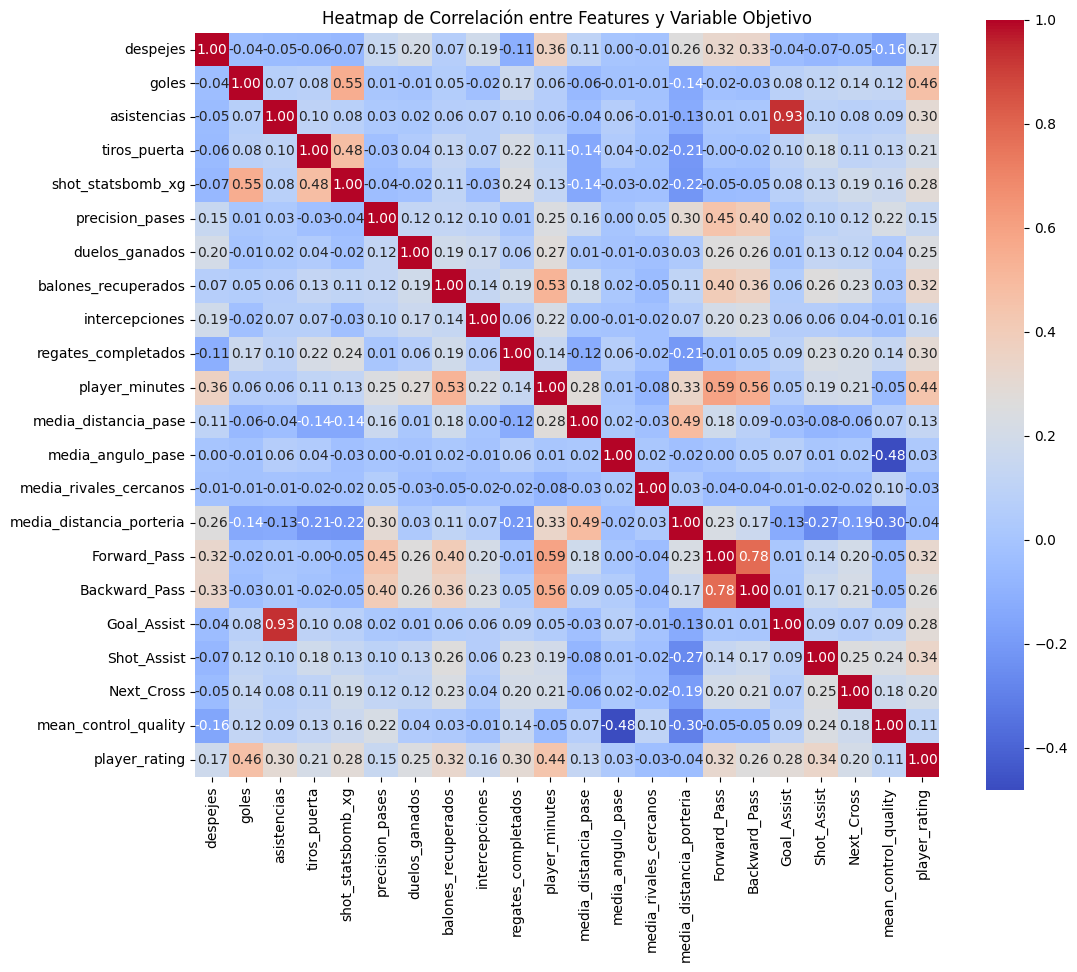

In [64]:
# Crear heatmap de correlación para las features y la variable objetivo
plt.figure(figsize=(12, 10))
sns.heatmap(df_final[features_c + ['mean_control_quality', 'player_rating']].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Heatmap de Correlación entre Features y Variable Objetivo')
plt.show()


De primeras no parece que el control orientado esté relacionado linearmente con el rating

In [65]:
partidos_jugados = df_final.groupby(['player_name'])['player_rating'].size().reset_index(name='num_matches').sort_values(by='num_matches', ascending=False)
partidos_jugados

,player_name,num_matches
409,Mikel Oyarzabal,7
632,Álvaro Morata,7
331,Lamine Yamal,7
407,Mike Maignan,6
421,N'Golo Kanté,6
...,...,...
2,A. Bastoni,1
1,A. Barák,1
638,Ž. Karničnik,1
16,A. Živković,1


In [66]:
partidos_jugados[partidos_jugados['num_matches'] < 3]

,player_name,num_matches
18,Adam Buksa,2
0,A. Bah,2
19,Adam Gnezda Cerin,2
22,Adrian Rus,2
4,A. Christensen,2
...,...,...
2,A. Bastoni,1
1,A. Barák,1
638,Ž. Karničnik,1
16,A. Živković,1


Vemos que muchos jugadores tienen pocos partidos, pero al final nos da igual porque predecimos el rating de los jugadores segun sus estadisticas en ese partido, no el rating de los jugadores en general. Por lo tanto, no es necesario filtrar por partidos jugados.
Cada jugador en cada partido puede jugar diferente, no es necesario que juegue un mínimo de partidos para predecir su rating en un partido concreto.

Como vamos a utilizar métricas mas propias de jugadores de campo y no de los porteros, vamos a borrar los datos de los porteros para nuestro dataset final

In [67]:
import ast
porteros= []
tactics = df_sub_events[df_sub_events['tactics'].notna()]
for tactic in tactics['tactics']:
    print(type(tactic))
    print(tactic)
    # Convertir la cadena a un diccionario
    tactic_dict = ast.literal_eval(tactic)
    print(tactic_dict)
    print(len(tactic_dict['lineup']))
    # for player in tactic_dict['lineup']:
    # Imprimir los nombres de los jugadores cuya posicionen es 'GK'
    porteros.append([player['player']['name'] for player in tactic_dict['lineup'] if player['position']['name'] == 'Goalkeeper'])
    print(porteros[-1])
print(porteros)
porteros = [item for sublist in porteros for item in sublist]
porteros = set(porteros)
print(len(porteros))
print(porteros)

<class 'str'>
{'formation': 4231, 'lineup': [{'player': {'id': 37274, 'name': 'Bart Verbruggen'}, 'position': {'id': 1, 'name': 'Goalkeeper'}, 'jersey_number': 1}, {'player': {'id': 8125, 'name': 'Denzel Dumfries'}, 'position': {'id': 2, 'name': 'Right Back'}, 'jersey_number': 22}, {'player': {'id': 7787, 'name': 'Stefan de Vrij'}, 'position': {'id': 3, 'name': 'Right Center Back'}, 'jersey_number': 6}, {'player': {'id': 3669, 'name': 'Virgil van Dijk'}, 'position': {'id': 5, 'name': 'Left Center Back'}, 'jersey_number': 4}, {'player': {'id': 3306, 'name': 'Nathan Aké'}, 'position': {'id': 6, 'name': 'Left Back'}, 'jersey_number': 5}, {'player': {'id': 15503, 'name': 'Jerdy Schouten'}, 'position': {'id': 9, 'name': 'Right Defensive Midfield'}, 'jersey_number': 24}, {'player': {'id': 21582, 'name': 'Tijjani Reijnders'}, 'position': {'id': 11, 'name': 'Left Defensive Midfield'}, 'jersey_number': 14}, {'player': {'id': 15582, 'name': 'Donyell Malen'}, 'position': {'id': 17, 'name': 'Right

In [68]:
# Eliminar porteros de df_final
df_final_no_gk = df_final[~df_final['player_name'].isin(porteros)]
df_final_scaled_no_gk = df_final_scaled[~df_final_scaled['player_name'].isin(porteros)]
df_final_no_gk.shape, df_final_scaled_no_gk.shape

((1442, 33), (1442, 33))

In [69]:
df_final_no_gk

,match_id_x,match_date,player_id,player_name,team_id,team_name,player_rating,player_minutes,match_id_statsbomb,clean_player_name_x,...,mean_control_quality,media_distancia_pase,media_angulo_pase,media_rivales_cercanos,media_distancia_porteria,Forward_Pass,Backward_Pass,Goal_Assist,Shot_Assist,Next_Cross
0,19032613.0,2024-06-14,1078.0,A. Robertson,18706.0,Scotland,6.20,90.0,3930158.0,a robertson,...,0.130679,15.649942,1.477897,0.0,70.201544,15.0,6.0,0.0,0.0,1.0
2,19032613.0,2024-06-14,173129.0,Anthony Ralston,18706.0,Scotland,5.58,90.0,3930158.0,anthony ralston,...,0.171868,17.376565,-1.848778,0.0,84.661852,10.0,4.0,0.0,0.0,0.0
3,19032613.0,2024-06-14,31837.0,Antonio Rüdiger,18660.0,Germany,6.42,90.0,3930158.0,antonio rüdiger,...,0.179323,18.347110,-0.585092,0.0,66.299676,53.0,20.0,0.0,0.0,1.0
4,19032613.0,2024-06-14,6599973.0,Billy Gilmour,18706.0,Scotland,5.99,23.0,3930158.0,billy gilmour,...,0.178576,11.718941,-1.200267,0.0,69.755309,6.0,0.0,0.0,0.0,0.0
5,19032613.0,2024-06-14,8585.0,Callum McGregor,18706.0,Scotland,5.98,67.0,3930158.0,callum mcgregor,...,0.152923,12.007662,0.135858,0.0,70.012506,5.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,19032598.0,2024-07-14,336133.0,Phil Foden,18645.0,England,6.94,89.0,3943043.0,phil foden,...,0.149739,14.681525,0.181279,0.0,74.949803,9.0,2.0,0.0,0.0,0.0
1573,19032598.0,2024-07-14,100580.0,Robin Le Normand,18710.0,Spain,7.04,83.0,3943043.0,robin le normand,...,0.170866,21.105173,-0.708169,0.0,74.354743,41.0,12.0,0.0,0.0,1.0
1574,19032598.0,2024-07-14,186910.0,Rodri,18710.0,Spain,6.94,46.0,3943043.0,rodri,...,0.177289,19.614870,0.044103,0.0,63.100199,13.0,3.0,0.0,0.0,0.0
1575,19032598.0,2024-07-14,187215.0,Unai Simón,18710.0,Spain,6.63,90.0,3943043.0,unai simón,...,0.111966,21.575071,0.214429,0.0,97.614454,19.0,6.0,0.0,0.0,0.0


Nos quedamos con 1442 ratings que nos serviran para entrenar nuestros modelos

In [ ]:
# df_final_no_gk.to_csv('df_final_no_gk_eur_masc_2024.csv', index=False)
# df_final_scaled_no_gk.to_csv('df_final_scaled_no_gk_eur_masc_2024.csv', index=False)

In [71]:
X = df_final_no_gk[features_list + ['player_minutes']]
X_scaled = df_final_scaled_no_gk[features_list + ['player_minutes']]

y = df_final_no_gk['player_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [72]:
#Eliminar columna Goal_Assist de las features_c ya que es lo mismo que asistencias
features_c.remove('Goal_Assist')

In [73]:
X_train_a = X_train[features_a]
X_test_a = X_test[features_a]
X_train_b = X_train[features_b]
X_test_b = X_test[features_b]
X_train_c = X_train[features_c]
X_test_c = X_test[features_c]

X_train_a_scaled = X_train_scaled[features_a]
X_test_a_scaled = X_test_scaled[features_a]
X_train_b_scaled = X_train_scaled[features_b]
X_test_b_scaled = X_test_scaled[features_b]
X_train_c_scaled = X_train_scaled[features_c]
X_test_c_scaled = X_test_scaled[features_c]

In [74]:
conjunto_datos = {'Modelo A': (X_train_a, X_test_a, y_train, y_test),
                 'Modelo A Escalado': (X_train_a_scaled, X_test_a_scaled, y_train_scaled, y_test_scaled),
                 'Modelo B': (X_train_b, X_test_b, y_train, y_test),
                 'Modelo B Escalado': (X_train_b_scaled, X_test_b_scaled, y_train_scaled, y_test_scaled),
                 'Modelo C': (X_train_c, X_test_c, y_train, y_test),
                 'Modelo C Escalado': (X_train_c_scaled, X_test_c_scaled, y_train_scaled, y_test_scaled)}

In [75]:
for nombre in conjunto_datos:
    X_train, X_test, y_train, y_test = conjunto_datos[nombre]
    print(f"{nombre}:")
    print(f"  Tamaño de X_train: {X_train.shape}")
    print(f"  Tamaño de X_test: {X_test.shape}")
    print(f"  Tamaño de y_train: {y_train.shape}")
    print(f"  Tamaño de y_test: {y_test.shape}\n")

Modelo A:
  Tamaño de X_train: (1225, 11)
  Tamaño de X_test: (217, 11)
  Tamaño de y_train: (1225,)
  Tamaño de y_test: (217,)

Modelo A Escalado:
  Tamaño de X_train: (1153, 11)
  Tamaño de X_test: (289, 11)
  Tamaño de y_train: (1153,)
  Tamaño de y_test: (289,)

Modelo B:
  Tamaño de X_train: (1225, 12)
  Tamaño de X_test: (217, 12)
  Tamaño de y_train: (1225,)
  Tamaño de y_test: (217,)

Modelo B Escalado:
  Tamaño de X_train: (1153, 12)
  Tamaño de X_test: (289, 12)
  Tamaño de y_train: (1153,)
  Tamaño de y_test: (289,)

Modelo C:
  Tamaño de X_train: (1225, 19)
  Tamaño de X_test: (217, 19)
  Tamaño de y_train: (1225,)
  Tamaño de y_test: (217,)

Modelo C Escalado:
  Tamaño de X_train: (1153, 19)
  Tamaño de X_test: (289, 19)
  Tamaño de y_train: (1153,)
  Tamaño de y_test: (289,)



# Modelos de regresión

In [80]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, root_mean_squared_error
from sklearn.inspection import permutation_importance
from scipy.stats import ttest_rel, f_oneway
from statsmodels.tools.eval_measures import aic, bic
from statsmodels.stats.proportion import proportions_ztest
import shap
# Quitar los warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

c:\Users\antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Vamos a probar a ir modelo a modelo 

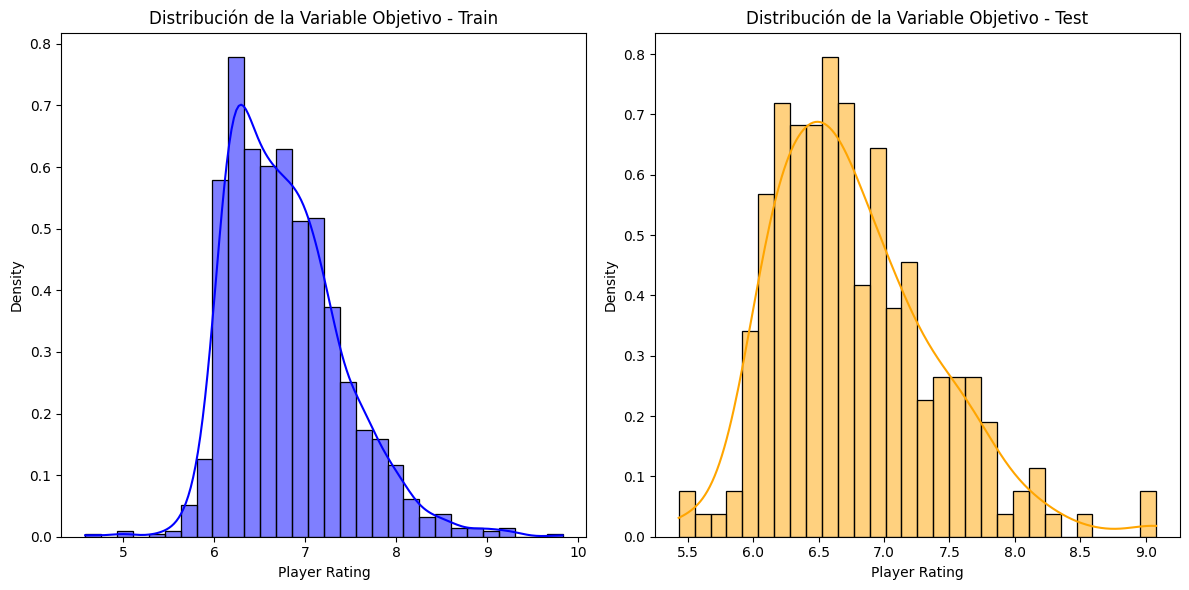

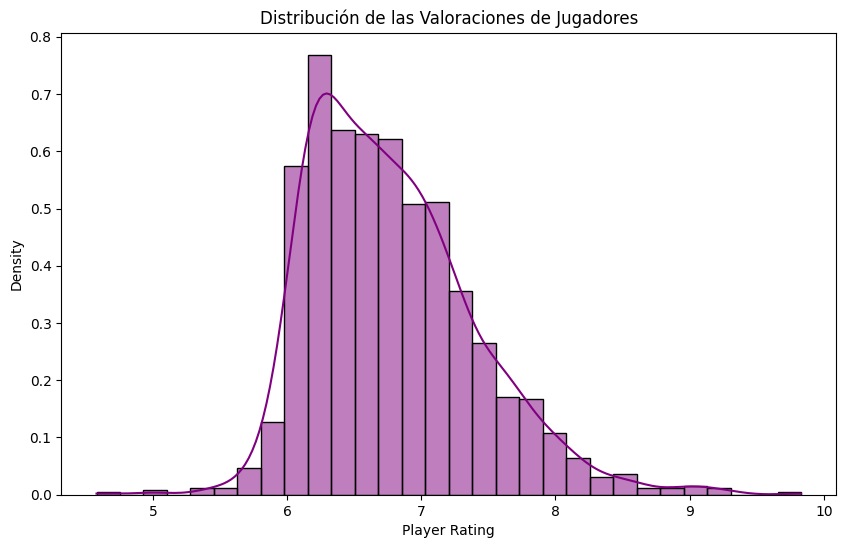

In [ ]:
# Plot the distribution of training and testing data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, color='blue', label='Train', stat='density', bins=30)
plt.title('Distribución de la Variable Objetivo - Train')
plt.xlabel('Player Rating')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.histplot(y_test, kde=True, color='orange', label='Test', stat='density', bins=30)
plt.title('Distribución de la Variable Objetivo - Test')
plt.xlabel('Player Rating')
plt.ylabel('Density')
plt.tight_layout()
plt.show()
# Plot the distribution of player ratings
plt.figure(figsize=(10, 6))
sns.histplot(df_final_no_gk['player_rating'], kde=True, color='purple', stat='density', bins=30)
plt.title('Distribución de las Valoraciones de Jugadores')
plt.xlabel('Player Rating')
plt.ylabel('Density')
plt.show()



In [ ]:
X_train_c.columns

Index(['despejes', 'goles', 'asistencias', 'tiros_puerta', 'shot_statsbomb_xg',
       'precision_pases', 'duelos_ganados', 'balones_recuperados',
       'intercepciones', 'regates_completados', 'player_minutes',
       'media_distancia_pase', 'media_angulo_pase', 'media_rivales_cercanos',
       'media_distancia_porteria', 'Forward_Pass', 'Backward_Pass',
       'Goal_Assist', 'Shot_Assist', 'Next_Cross'],
      dtype='object')

### Ridge


--- Entrenando y evaluando Modelo A ---
Mejores parámetros: {'alpha': 0.1}
MAE: 0.2961, RMSE: 0.4004, R2: 0.5740

--- Entrenando y evaluando Modelo A Escalado ---
Mejores parámetros: {'alpha': 0.1}
MAE: 0.3044, RMSE: 0.4029, R2: 0.5344

--- Entrenando y evaluando Modelo B ---
Mejores parámetros: {'alpha': 1.0}
MAE: 0.2976, RMSE: 0.4007, R2: 0.5734

--- Entrenando y evaluando Modelo B Escalado ---
Mejores parámetros: {'alpha': 0.1}
MAE: 0.3052, RMSE: 0.4032, R2: 0.5338

--- Entrenando y evaluando Modelo C ---
Mejores parámetros: {'alpha': 0.1}
MAE: 0.3025, RMSE: 0.3965, R2: 0.5822

--- Entrenando y evaluando Modelo C Escalado ---
Mejores parámetros: {'alpha': 1.0}
MAE: 0.3029, RMSE: 0.3937, R2: 0.5554

--- Comparación Modelo A vs Modelo B ---
t-test p-value: 0.4261
F-test p-value: 0.9874
Likelihood Ratio Test (Z-test) p-value: 0.5271
AIC: -433.4048, BIC: -434.3622
Aumento relativo de R2 (Modelo A→Modelo B): 0.1%
Reducción relativa de RMSE (Modelo A→Modelo B): -0.1%
Reducción relativa d

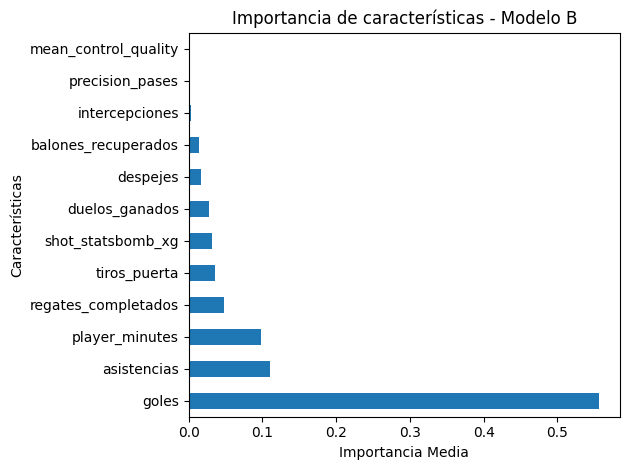

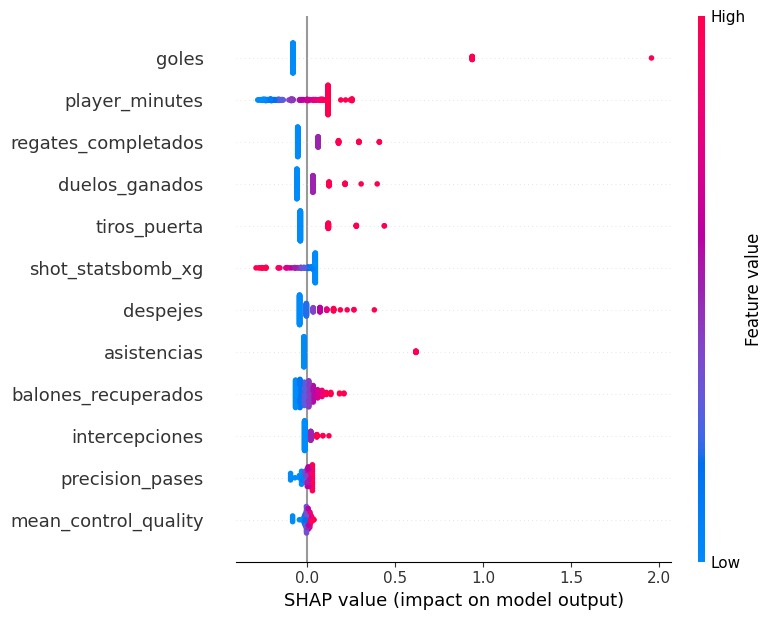


Importancia de features (Modelo C):
goles                  0.546409
asistencias            0.089818
player_minutes         0.058546
Forward_Pass           0.057981
regates_completados    0.040037
despejes               0.029902
Shot_Assist            0.028988
tiros_puerta           0.028803
duelos_ganados         0.024727
shot_statsbomb_xg      0.016706
dtype: float64


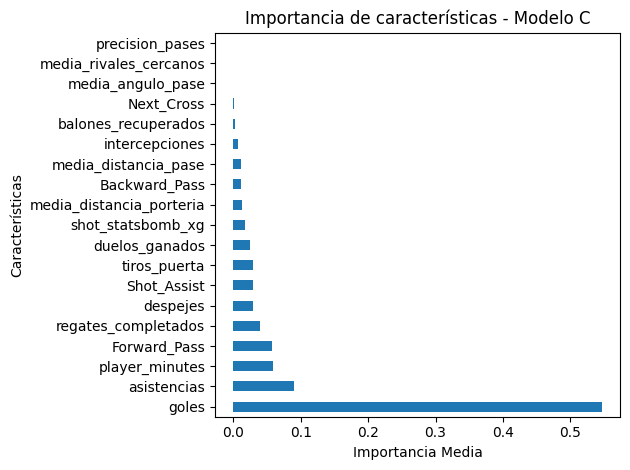

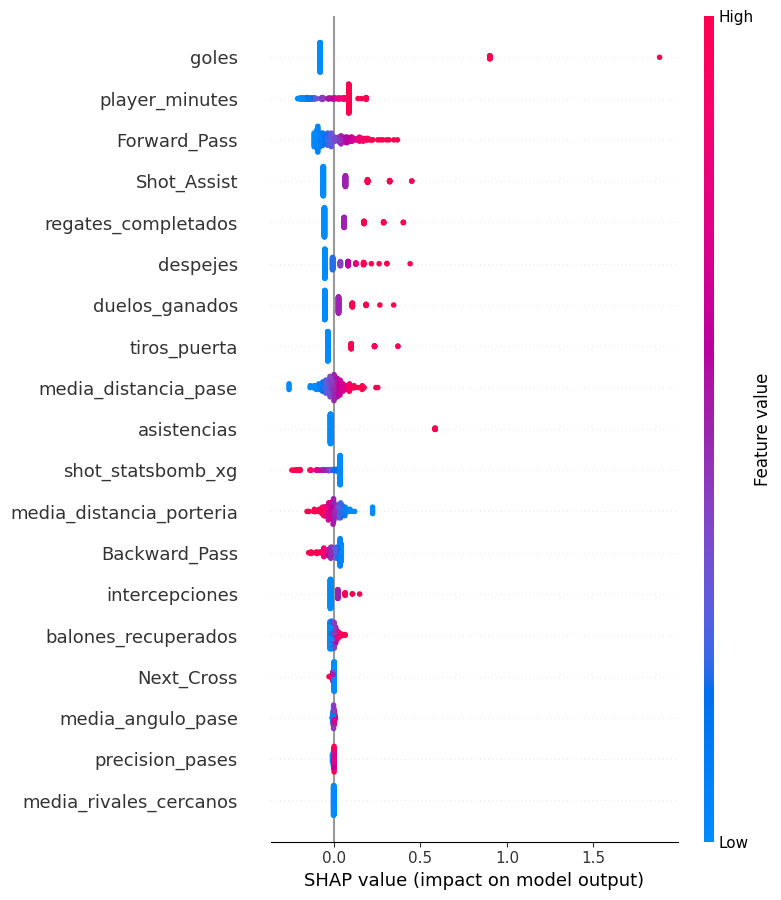

In [81]:
# Diccionario de resultados
resultados_modelo_Ridge = {}

# Parámetros para la búsqueda
# param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}
# Parametro para busqueda con Ridge
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}
# Iterar sobre cada conjunto
for nombre, (X_train, X_test, y_train, y_test) in conjunto_datos.items():
    print(f"\n--- Entrenando y evaluando {nombre} ---")
    
    # 1. Optimización del modelo
    grid = GridSearchCV(Ridge(random_state=42), param_grid_ridge, cv=5, scoring='neg_root_mean_squared_error')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    # 2. Evaluación en test
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_adj = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    # 3. Validación cruzada (MAE)
    X_total = np.vstack((X_train, X_test))
    y_total = np.concatenate((y_train, y_test))
    cv_mae = -cross_val_score(best_model, X_total, y_total, cv=5, scoring='neg_mean_absolute_error')
    
    # 4. Guardar resultados
    resultados_modelo_Ridge[nombre] = {
        'modelo': best_model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'r2_adj': r2_adj,
        'cv_mae': cv_mae,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        
    }

# --- Comparaciones entre pares de modelos ---
pares = [('Modelo A', 'Modelo B'), ('Modelo B', 'Modelo C'), ('Modelo A Escalado', 'Modelo B Escalado'),
         ('Modelo B Escalado', 'Modelo C Escalado')]

for m1, m2 in pares:
    print(f"\n--- Comparación {m1} vs {m2} ---")
    cv_mae_1 = resultados_modelo_Ridge[m1]['cv_mae']
    cv_mae_2 = resultados_modelo_Ridge[m2]['cv_mae']
    
    # t-test
    t_stat, p_val = ttest_rel(cv_mae_1, cv_mae_2)
    print(f"t-test p-value: {p_val:.4f}")
    
    # F-test
    f_stat, p_val_f = f_oneway(cv_mae_1, cv_mae_2)
    print(f"F-test p-value: {p_val_f:.4f}")
    
    # Likelihood Ratio Test (Z-test sobre número de veces que uno gana al otro)
    z_stat, p_val_lr = proportions_ztest([np.sum(cv_mae_1 < cv_mae_2), np.sum(cv_mae_2 < cv_mae_1)],
                                         [len(cv_mae_1), len(cv_mae_2)])
    print(f"Likelihood Ratio Test (Z-test) p-value: {p_val_lr:.4f}")
    
    # AIC y BIC
    aic_val = aic(len(resultados_modelo_Ridge[m1]['y_test']),
                  resultados_modelo_Ridge[m1]['mae'],
                  resultados_modelo_Ridge[m2]['mae'])
    bic_val = bic(len(resultados_modelo_Ridge[m1]['y_test']),
                  resultados_modelo_Ridge[m1]['mae'],
                  resultados_modelo_Ridge[m2]['mae'])
    print(f"AIC: {aic_val:.4f}, BIC: {bic_val:.4f}")
    
    # Delta MAE
    delta_mae = (resultados_modelo_Ridge[m1]['mae'] - resultados_modelo_Ridge[m2]['mae']) / resultados_modelo_Ridge[m1]['mae']
    # Delta RMSE
    delta_rmse = (resultados_modelo_Ridge[m1]['rmse'] - resultados_modelo_Ridge[m2]['rmse']) / resultados_modelo_Ridge[m1]['rmse']
    # Delta R2
    delta_r2 = (resultados_modelo_Ridge[m1]['r2'] - resultados_modelo_Ridge[m2]['r2']) / resultados_modelo_Ridge[m1]['r2']
    print(f"Aumento relativo de R2 ({m1}→{m2}): {delta_r2:.1%}")
    print(f"Reducción relativa de RMSE ({m1}→{m2}): {delta_rmse:.1%}")
    print(f"Reducción relativa de MAE ({m1}→{m2}): {delta_mae:.1%}")

# --- Importancia de variables y SHAP para modelos no escalados ---
for nombre in ['Modelo B', 'Modelo C']:
    model = resultados_modelo_Ridge[nombre]['modelo']
    X_test = resultados_modelo_Ridge[nombre]['X_test']
    y_test = resultados_modelo_Ridge[nombre]['y_test']
    features = X_test.columns if isinstance(X_test, pd.DataFrame) else [f'feat_{i}' for i in range(X_test.shape[1])]
    
    # Permutation Importance
    importance = permutation_importance(model, X_test, y_test, n_repeats=10)
    importances_series = pd.Series(importance.importances_mean, index=features)
    print(f"\nImportancia de features ({nombre}):")
    print(importances_series.sort_values(ascending=False).head(10))
    # Visualización de la importancia de las características con features en eje y
    importances_series.sort_values(ascending=False).plot(kind='barh', title=f'Importancia de características - {nombre}')
    plt.xlabel('Importancia Media')
    plt.ylabel('Características')
    plt.tight_layout()
    plt.show()
    # SHAP
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=features)
    
    
    # # SHAP
    # explainer = shap.TreeExplainer(model)
    # shap_values = explainer.shap_values(X_test)
    # shap.summary_plot(shap_values, X_test, feature_names=features)


In [82]:
resultados_modelo_Ridge

{'Modelo A': {'modelo': Ridge(alpha=0.1, random_state=42),
  'mae': np.float64(0.29612793129674764),
  'rmse': np.float64(0.40038962656770405),
  'r2': 0.5739668495116284,
  'r2_adj': 0.5511065341195693,
  'cv_mae': array([0.30650592, 0.33399283, 0.28744246, 0.31744811, 0.28637438]),
  'X_test':       despejes  goles  asistencias  tiros_puerta  shot_statsbomb_xg  \
  434        0.0    0.0          0.0           0.0           0.000000   
  635        0.0    0.0          0.0           0.0           0.000000   
  583        0.0    0.0          0.0           0.0           0.042105   
  69         0.0    1.0          1.0           0.0           0.056130   
  398        0.0    0.0          0.0           0.0           0.000000   
  ...        ...    ...          ...           ...                ...   
  1567       5.0    0.0          0.0           0.0           0.117154   
  1301       5.0    0.0          0.0           0.0           0.000000   
  1188       0.0    1.0          0.0           0

In [ ]:
# resultados_modelo_RandomForest a dataframe
resultados_modelo_Ridge_rmse = pd.DataFrame.from_dict(resultados_modelo_Ridge, orient='index')

,mae,rmse,r2,r2_adj,alpha
Modelo A,0.296128,0.400390,0.573967,0.551107,0.1
Modelo A Escalado,0.304402,0.402937,0.534391,0.515901,0.1
Modelo B,0.297588,0.400668,0.573373,0.548278,1.0
Modelo B Escalado,0.305218,0.403185,0.533819,0.513550,0.1
Modelo C,0.302497,0.396494,0.582217,0.541923,0.1
Modelo C Escalado,0.302900,0.393738,0.555409,0.524007,1.0


### Random Forest


--- Entrenando y evaluando Modelo A ---
Mejores parámetros: {'max_depth': 9, 'n_estimators': 200}
MAE: 0.3194, RMSE: 0.4215, R2: 0.5280

--- Entrenando y evaluando Modelo A Escalado ---
Mejores parámetros: {'max_depth': 9, 'n_estimators': 200}
MAE: 0.3180, RMSE: 0.4176, R2: 0.4998

--- Entrenando y evaluando Modelo B ---
Mejores parámetros: {'max_depth': 9, 'n_estimators': 200}
MAE: 0.3231, RMSE: 0.4253, R2: 0.5193

--- Entrenando y evaluando Modelo B Escalado ---
Mejores parámetros: {'max_depth': 9, 'n_estimators': 200}
MAE: 0.3147, RMSE: 0.4178, R2: 0.4993

--- Entrenando y evaluando Modelo C ---
Mejores parámetros: {'max_depth': None, 'n_estimators': 200}
MAE: 0.3201, RMSE: 0.4222, R2: 0.5263

--- Entrenando y evaluando Modelo C Escalado ---
Mejores parámetros: {'max_depth': None, 'n_estimators': 200}
MAE: 0.3157, RMSE: 0.4146, R2: 0.5070

--- Comparación Modelo A vs Modelo B ---
t-test p-value: 0.1694
F-test p-value: 0.8838
Likelihood Ratio Test (Z-test) p-value: 0.0578
AIC: -433.

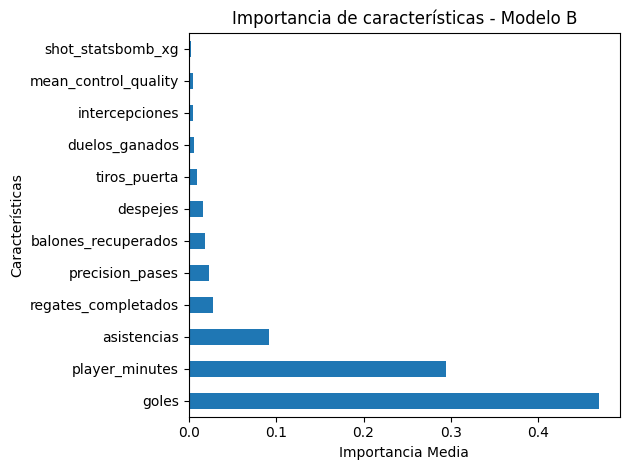

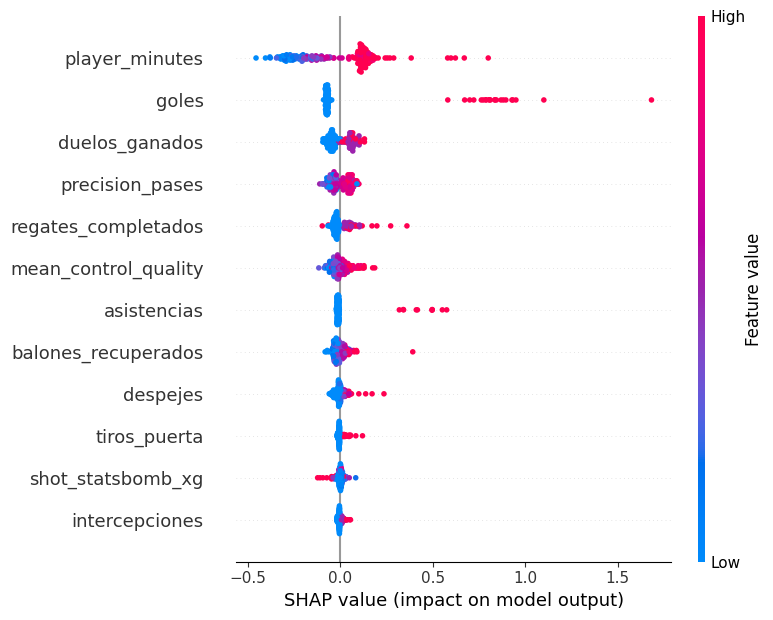


Importancia de features (Modelo C):
goles                       0.377604
player_minutes              0.177117
asistencias                 0.088631
Shot_Assist                 0.030061
Forward_Pass                0.028872
media_distancia_porteria    0.019479
despejes                    0.018369
regates_completados         0.018291
Backward_Pass               0.017707
balones_recuperados         0.016952
dtype: float64


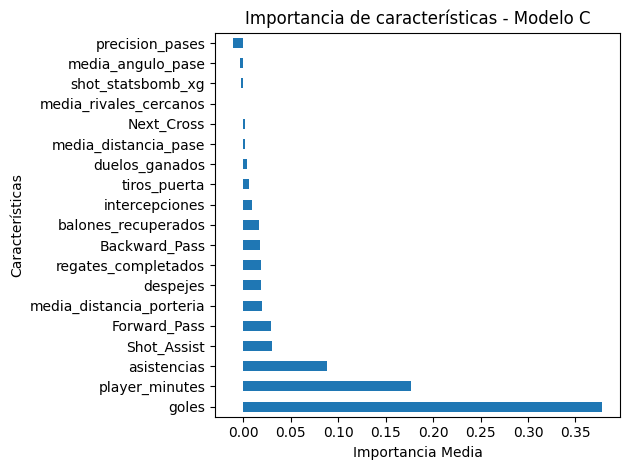

 98%|===================| 213/217 [00:24<00:00]        

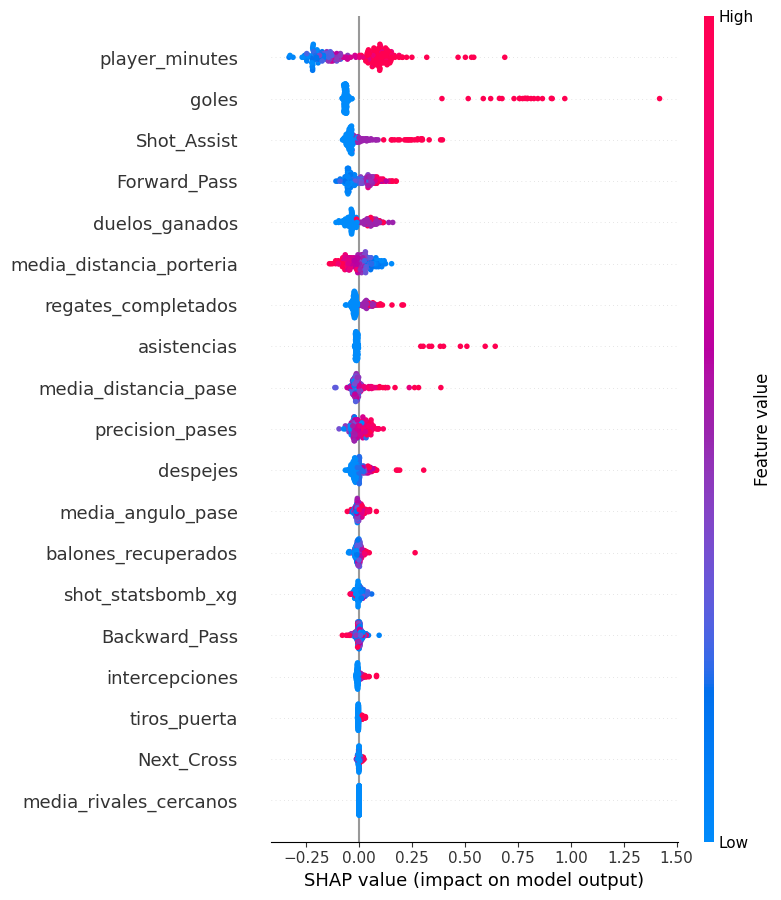

In [84]:
# Diccionario de resultados
resultados_modelo_RandomForest = {}

# Parámetros para la búsqueda
# param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}
# Parametro para busqueda con Ridge
param_grid_ridge = {'n_estimators': [50, 100, 200], 'max_depth': [None, 3, 6, 9]}
# Iterar sobre cada conjunto
for nombre, (X_train, X_test, y_train, y_test) in conjunto_datos.items():
    print(f"\n--- Entrenando y evaluando {nombre} ---")
    
    # 1. Optimización del modelo
    grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_ridge, cv=5, scoring='neg_root_mean_squared_error')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    # 2. Evaluación en test
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_adj = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    # 3. Validación cruzada (MAE)
    X_total = np.vstack((X_train, X_test))
    y_total = np.concatenate((y_train, y_test))
    cv_mae = -cross_val_score(best_model, X_total, y_total, cv=5, scoring='neg_mean_absolute_error')
    
    # 4. Guardar resultados
    resultados_modelo_RandomForest[nombre] = {
        'modelo': best_model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'r2_adj': r2_adj,
        'cv_mae': cv_mae,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'alpha': grid.best_params_,
    }

# --- Comparaciones entre pares de modelos ---
pares = [('Modelo A', 'Modelo B'), ('Modelo B', 'Modelo C'), ('Modelo A Escalado', 'Modelo B Escalado'),
         ('Modelo B Escalado', 'Modelo C Escalado')]

for m1, m2 in pares:
    print(f"\n--- Comparación {m1} vs {m2} ---")
    cv_mae_1 = resultados_modelo_RandomForest[m1]['cv_mae']
    cv_mae_2 = resultados_modelo_RandomForest[m2]['cv_mae']
    
    # t-test
    t_stat, p_val = ttest_rel(cv_mae_1, cv_mae_2)
    print(f"t-test p-value: {p_val:.4f}")
    
    # F-test
    f_stat, p_val_f = f_oneway(cv_mae_1, cv_mae_2)
    print(f"F-test p-value: {p_val_f:.4f}")
    
    # Likelihood Ratio Test (Z-test sobre número de veces que uno gana al otro)
    z_stat, p_val_lr = proportions_ztest([np.sum(cv_mae_1 < cv_mae_2), np.sum(cv_mae_2 < cv_mae_1)],
                                         [len(cv_mae_1), len(cv_mae_2)])
    print(f"Likelihood Ratio Test (Z-test) p-value: {p_val_lr:.4f}")
    
    # AIC y BIC
    aic_val = aic(len(resultados_modelo_RandomForest[m1]['y_test']),
                  resultados_modelo_RandomForest[m1]['mae'],
                  resultados_modelo_RandomForest[m2]['mae'])
    bic_val = bic(len(resultados_modelo_RandomForest[m1]['y_test']),
                  resultados_modelo_RandomForest[m1]['mae'],
                  resultados_modelo_RandomForest[m2]['mae'])
    print(f"AIC: {aic_val:.4f}, BIC: {bic_val:.4f}")
    
    # Delta MAE
    delta_mae = (resultados_modelo_RandomForest[m1]['mae'] - resultados_modelo_RandomForest[m2]['mae']) / resultados_modelo_RandomForest[m1]['mae']
    # Delta RMSE
    delta_rmse = (resultados_modelo_RandomForest[m1]['rmse'] - resultados_modelo_RandomForest[m2]['rmse']) / resultados_modelo_RandomForest[m1]['rmse']
    # Delta R2
    delta_r2 = (resultados_modelo_RandomForest[m1]['r2'] - resultados_modelo_RandomForest[m2]['r2']) / resultados_modelo_RandomForest[m1]['r2']
    print(f"Aumento relativo de R2 ({m1}→{m2}): {delta_r2:.1%}")
    print(f"Reducción relativa de RMSE ({m1}→{m2}): {delta_rmse:.1%}")
    print(f"Reducción relativa de MAE ({m1}→{m2}): {delta_mae:.1%}")

# --- Importancia de variables y SHAP para modelos no escalados ---
for nombre in ['Modelo B', 'Modelo C']:
    model = resultados_modelo_RandomForest[nombre]['modelo']
    X_test = resultados_modelo_RandomForest[nombre]['X_test']
    y_test = resultados_modelo_RandomForest[nombre]['y_test']
    features = X_test.columns if isinstance(X_test, pd.DataFrame) else [f'feat_{i}' for i in range(X_test.shape[1])]
    
    # Permutation Importance
    importance = permutation_importance(model, X_test, y_test, n_repeats=10)
    importances_series = pd.Series(importance.importances_mean, index=features)
    print(f"\nImportancia de features ({nombre}):")
    print(importances_series.sort_values(ascending=False).head(10))
    # Visualización de la importancia de las características con features en eje y
    importances_series.sort_values(ascending=False).plot(kind='barh', title=f'Importancia de características - {nombre}')
    plt.xlabel('Importancia Media')
    plt.ylabel('Características')
    plt.tight_layout()
    plt.show()
    # SHAP
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=features)
    
    
    # # SHAP
    # explainer = shap.TreeExplainer(model)
    # shap_values = explainer.shap_values(X_test)
    # shap.summary_plot(shap_values, X_test, feature_names=features)

In [85]:
# resultados_modelo_RandomForest a dataframe
resultados_modelo_RandomForest_rmse = pd.DataFrame.from_dict(resultados_modelo_RandomForest, orient='index')
resultados_modelo_RandomForest_rmse[['mae', 'rmse', 'r2','r2_adj', 'alpha']]

,mae,rmse,r2,r2_adj,alpha
Modelo A,0.319396,0.421455,0.527959,0.502630,"{'max_depth': 9, 'n_estimators': 200}"
Modelo A Escalado,0.318007,0.417624,0.499830,0.479967,"{'max_depth': 9, 'n_estimators': 200}"
Modelo B,0.323106,0.425318,0.519264,0.490986,"{'max_depth': 9, 'n_estimators': 200}"
Modelo B Escalado,0.314706,0.417848,0.499294,0.477524,"{'max_depth': 9, 'n_estimators': 200}"
Modelo C,0.320088,0.422187,0.526318,0.480632,"{'max_depth': None, 'n_estimators': 200}"
Modelo C Escalado,0.315711,0.414629,0.506977,0.472154,"{'max_depth': None, 'n_estimators': 200}"


### Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


--- Entrenando y evaluando Modelo A ---
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
MAE: 0.3194, RMSE: 0.4180, R2: 0.5356

--- Entrenando y evaluando Modelo A Escalado ---
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
MAE: 0.3204, RMSE: 0.4167, R2: 0.5020

--- Entrenando y evaluando Modelo B ---
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
MAE: 0.3204, RMSE: 0.4167, R2: 0.5385

--- Entrenando y evaluando Modelo B Escalado ---
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
MAE: 0.3184, RMSE: 0.4154, R2: 0.5052

--- Entrenando y evaluando Modelo C ---
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
MAE: 0.3232, RMSE: 0.4172, R2: 0.5375

--- Entrenando y evaluando Modelo C Escalado ---
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
MAE: 0.3211, RMSE: 0.4118, R2: 0.5137

--- Comparación Mo

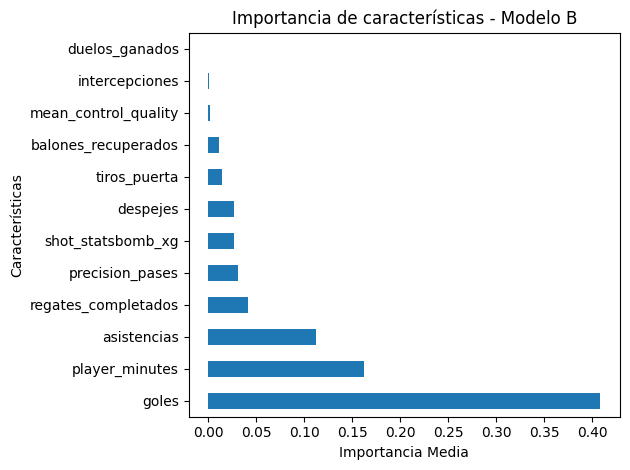

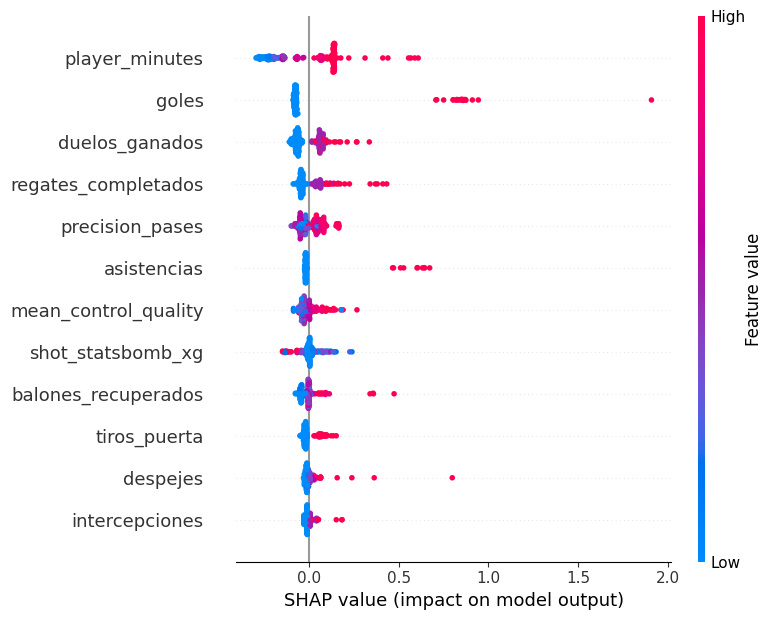


Importancia de features (Modelo C):
goles                       0.358221
asistencias                 0.104802
player_minutes              0.103221
media_distancia_porteria    0.046441
Forward_Pass                0.036851
regates_completados         0.034649
Shot_Assist                 0.026055
despejes                    0.025017
shot_statsbomb_xg           0.020044
tiros_puerta                0.009224
dtype: float64


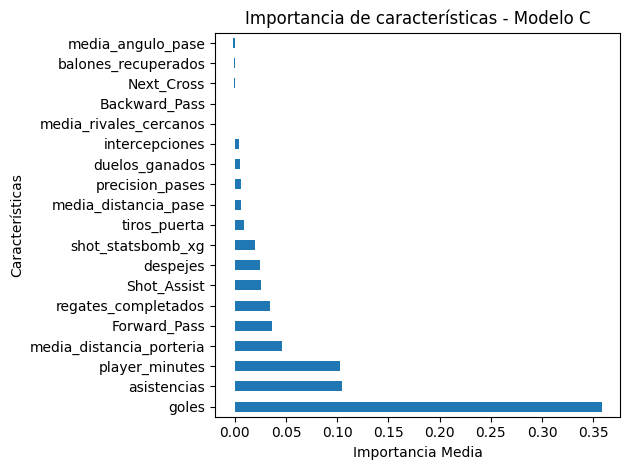

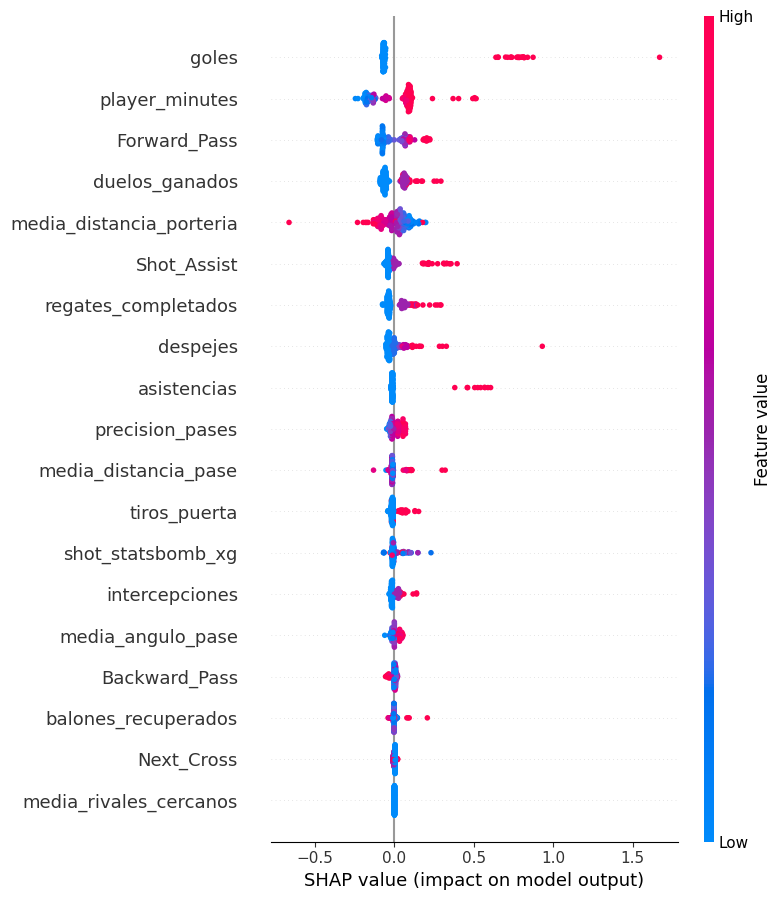

In [91]:
# Diccionario de resultados
resultados_modelo_GradientBoost = {}

# Parámetros para la búsqueda
# param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}
# Parametro para busqueda con Ridge
param_grid_ridge = {'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],'n_estimators': [50, 100, 200], 'max_depth': [1, 2, 3, 6, 9]}

# Iterar sobre cada conjunto
for nombre, (X_train, X_test, y_train, y_test) in conjunto_datos.items():
    print(f"\n--- Entrenando y evaluando {nombre} ---")
    
    # 1. Optimización del modelo
    grid = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_ridge, cv=5, scoring='neg_root_mean_squared_error')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    # 2. Evaluación en test
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_adj = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    # 3. Validación cruzada (MAE)
    X_total = np.vstack((X_train, X_test))
    y_total = np.concatenate((y_train, y_test))
    cv_mae = -cross_val_score(best_model, X_total, y_total, cv=5, scoring='neg_mean_absolute_error')
    
    # 4. Guardar resultados
    resultados_modelo_GradientBoost[nombre] = {
        'modelo': best_model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'r2_adj': r2_adj,
        'cv_mae': cv_mae,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'alpha': grid.best_params_,
    }

# --- Comparaciones entre pares de modelos ---
pares = [('Modelo A', 'Modelo B'), ('Modelo B', 'Modelo C'), ('Modelo A Escalado', 'Modelo B Escalado'),
         ('Modelo B Escalado', 'Modelo C Escalado')]

for m1, m2 in pares:
    print(f"\n--- Comparación {m1} vs {m2} ---")
    cv_mae_1 = resultados_modelo_GradientBoost[m1]['cv_mae']
    cv_mae_2 = resultados_modelo_GradientBoost[m2]['cv_mae']
    
    # t-test
    t_stat, p_val = ttest_rel(cv_mae_1, cv_mae_2)
    print(f"t-test p-value: {p_val:.4f}")
    
    # F-test
    f_stat, p_val_f = f_oneway(cv_mae_1, cv_mae_2)
    print(f"F-test p-value: {p_val_f:.4f}")
    
    # Likelihood Ratio Test (Z-test sobre número de veces que uno gana al otro)
    z_stat, p_val_lr = proportions_ztest([np.sum(cv_mae_1 < cv_mae_2), np.sum(cv_mae_2 < cv_mae_1)],
                                         [len(cv_mae_1), len(cv_mae_2)])
    print(f"Likelihood Ratio Test (Z-test) p-value: {p_val_lr:.4f}")
    
    # AIC y BIC
    aic_val = aic(len(resultados_modelo_GradientBoost[m1]['y_test']),
                  resultados_modelo_GradientBoost[m1]['mae'],
                  resultados_modelo_GradientBoost[m2]['mae'])
    bic_val = bic(len(resultados_modelo_GradientBoost[m1]['y_test']),
                  resultados_modelo_GradientBoost[m1]['mae'],
                  resultados_modelo_GradientBoost[m2]['mae'])
    print(f"AIC: {aic_val:.4f}, BIC: {bic_val:.4f}")
    
    # Delta MAE
    delta_mae = (resultados_modelo_GradientBoost[m1]['mae'] - resultados_modelo_GradientBoost[m2]['mae']) / resultados_modelo_GradientBoost[m1]['mae']
    # Delta RMSE
    delta_rmse = (resultados_modelo_GradientBoost[m1]['rmse'] - resultados_modelo_GradientBoost[m2]['rmse']) / resultados_modelo_GradientBoost[m1]['rmse']
    # Delta R2
    delta_r2 = (resultados_modelo_GradientBoost[m1]['r2'] - resultados_modelo_GradientBoost[m2]['r2']) / resultados_modelo_GradientBoost[m1]['r2']
    print(f"Aumento relativo de R2 ({m1}→{m2}): {delta_r2:.1%}")
    print(f"Reducción relativa de RMSE ({m1}→{m2}): {delta_rmse:.1%}")
    print(f"Reducción relativa de MAE ({m1}→{m2}): {delta_mae:.1%}")

# --- Importancia de variables y SHAP para modelos no escalados ---
for nombre in ['Modelo B', 'Modelo C']:
    model = resultados_modelo_GradientBoost[nombre]['modelo']
    X_test = resultados_modelo_GradientBoost[nombre]['X_test']
    y_test = resultados_modelo_GradientBoost[nombre]['y_test']
    features = X_test.columns if isinstance(X_test, pd.DataFrame) else [f'feat_{i}' for i in range(X_test.shape[1])]
    
    # Permutation Importance
    importance = permutation_importance(model, X_test, y_test, n_repeats=10)
    importances_series = pd.Series(importance.importances_mean, index=features)
    print(f"\nImportancia de features ({nombre}):")
    print(importances_series.sort_values(ascending=False).head(10))
    # Visualización de la importancia de las características con features en eje y
    importances_series.sort_values(ascending=False).plot(kind='barh', title=f'Importancia de características - {nombre}')
    plt.xlabel('Importancia Media')
    plt.ylabel('Características')
    plt.tight_layout()
    plt.show()
    # SHAP
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=features)
    
    
    # # SHAP
    # explainer = shap.TreeExplainer(model)
    # shap_values = explainer.shap_values(X_test)
    # shap.summary_plot(shap_values, X_test, feature_names=features)

In [92]:
# resultados_modelo_RandomForest a dataframe
resultados_modelo_GradientBoost_rmse = pd.DataFrame.from_dict(resultados_modelo_GradientBoost, orient='index')
resultados_modelo_GradientBoost_rmse[['mae', 'rmse', 'r2', 'r2_adj','alpha']] 

,mae,rmse,r2,r2_adj,alpha
Modelo A,0.319400,0.418032,0.535596,0.510677,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
Modelo A Escalado,0.320370,0.416724,0.501982,0.482205,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
Modelo B,0.320388,0.416731,0.538481,0.511333,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
Modelo B Escalado,0.318442,0.415366,0.505223,0.483711,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
Modelo C,0.323197,0.417176,0.537496,0.492889,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
Modelo C Escalado,0.321059,0.411804,0.513672,0.479322,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."


### SVR

In [95]:
from sklearn.svm import SVR


--- Entrenando y evaluando Modelo A ---
Mejores parámetros: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}
MAE: 0.3061, RMSE: 0.4015, R2: 0.5716

--- Entrenando y evaluando Modelo A Escalado ---
Mejores parámetros: {'C': 1, 'epsilon': 0.1, 'gamma': 0.01}
MAE: 0.3072, RMSE: 0.3978, R2: 0.5461

--- Entrenando y evaluando Modelo B ---
Mejores parámetros: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}
MAE: 0.3061, RMSE: 0.4016, R2: 0.5713

--- Entrenando y evaluando Modelo B Escalado ---
Mejores parámetros: {'C': 1, 'epsilon': 0.01, 'gamma': 0.01}
MAE: 0.3036, RMSE: 0.3985, R2: 0.5445

--- Entrenando y evaluando Modelo C ---
Mejores parámetros: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}
MAE: 0.3123, RMSE: 0.4118, R2: 0.5494

--- Entrenando y evaluando Modelo C Escalado ---
Mejores parámetros: {'C': 1, 'epsilon': 0.1, 'gamma': 0.01}
MAE: 0.3015, RMSE: 0.3917, R2: 0.5600

--- Comparación Modelo A vs Modelo B ---
t-test p-value: 0.0496
F-test p-value: 0.9822
Likelihood Ratio Test (Z-test) p-va

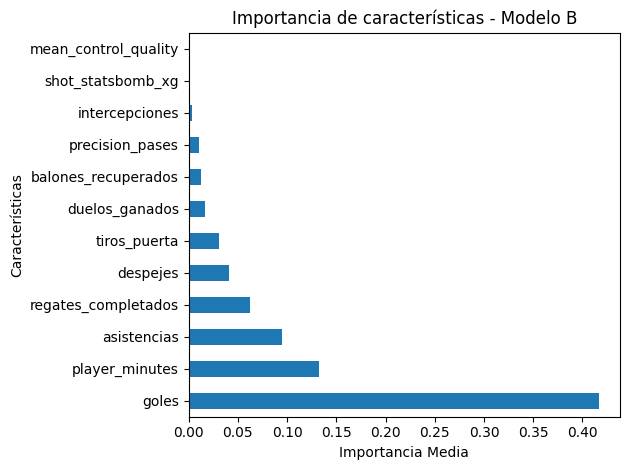

PermutationExplainer explainer: 218it [10:49,  3.00s/it]                         
C:\Users\antonio\AppData\Local\Temp\ipykernel_14652\984443503.py:108: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=features)


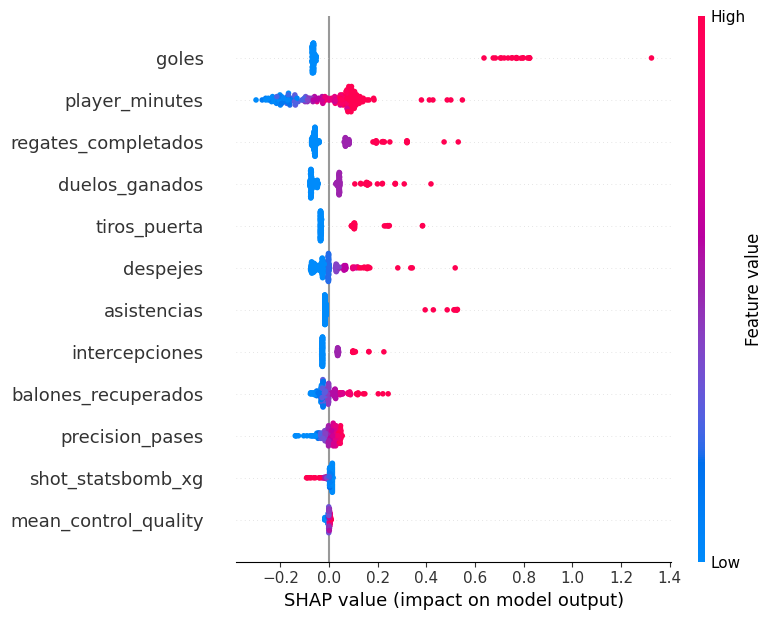


Importancia de features (Modelo C):
goles                       0.337709
player_minutes              0.203403
media_distancia_porteria    0.176510
Forward_Pass                0.089325
asistencias                 0.075474
regates_completados         0.046997
despejes                    0.045078
Backward_Pass               0.025757
duelos_ganados              0.020681
Shot_Assist                 0.017885
dtype: float64


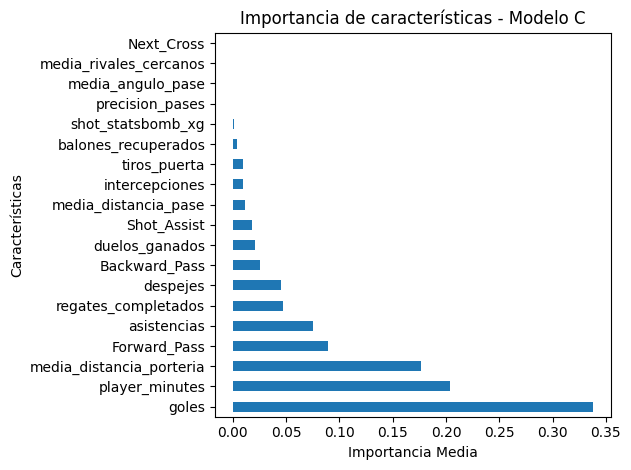

PermutationExplainer explainer: 218it [1:56:01, 32.53s/it]                              
C:\Users\antonio\AppData\Local\Temp\ipykernel_14652\984443503.py:108: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=features)


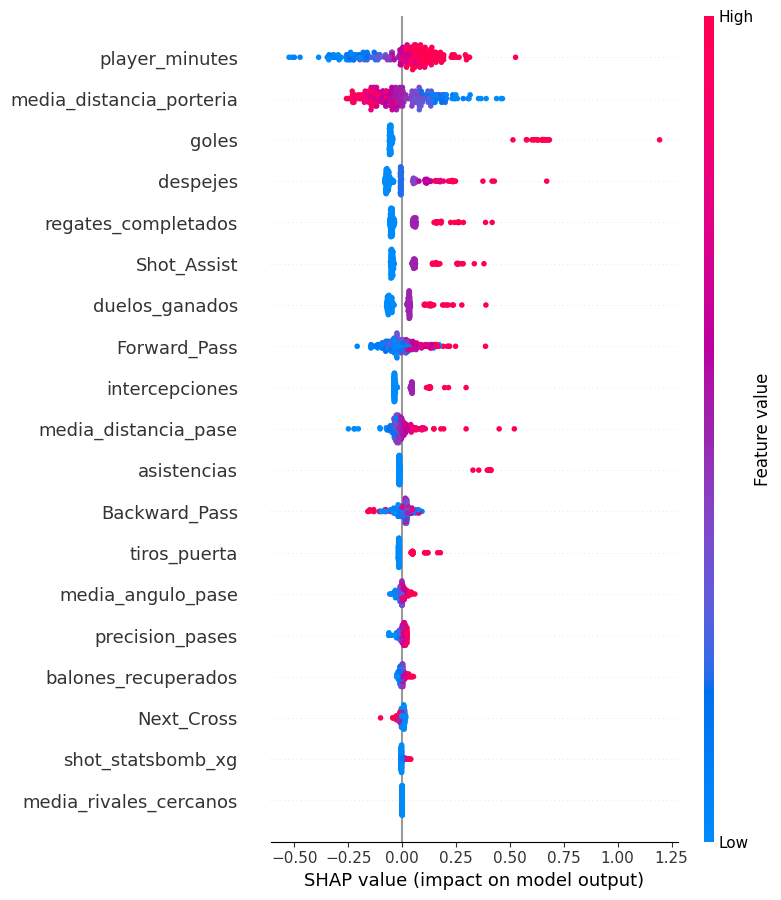

In [96]:
# Diccionario de resultados
resultados_modelo_SVR = {}

# Parámetros para la búsqueda
# param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}
# Parametro para busqueda con Ridge
param_grid_svr = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 'scale'], 'epsilon': [0.01, 0.1, 0.5, 1]}

# Iterar sobre cada conjunto
for nombre, (X_train, X_test, y_train, y_test) in conjunto_datos.items():
    print(f"\n--- Entrenando y evaluando {nombre} ---")
    
    # 1. Optimización del modelo
    grid = GridSearchCV(SVR(kernel='rbf'), param_grid_svr, cv=5, scoring='neg_root_mean_squared_error')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    # 2. Evaluación en test
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_adj = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    # 3. Validación cruzada (MAE)
    X_total = np.vstack((X_train, X_test))
    y_total = np.concatenate((y_train, y_test))
    cv_mae = -cross_val_score(best_model, X_total, y_total, cv=5, scoring='neg_mean_absolute_error')
    
    # 4. Guardar resultados
    resultados_modelo_SVR[nombre] = {
        'modelo': best_model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'r2_adj': r2_adj,
        'cv_mae': cv_mae,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'alpha': grid.best_params_,
    }

# --- Comparaciones entre pares de modelos ---
pares = [('Modelo A', 'Modelo B'), ('Modelo B', 'Modelo C'), ('Modelo A Escalado', 'Modelo B Escalado'),
         ('Modelo B Escalado', 'Modelo C Escalado')]

for m1, m2 in pares:
    print(f"\n--- Comparación {m1} vs {m2} ---")
    cv_mae_1 = resultados_modelo_SVR[m1]['cv_mae']
    cv_mae_2 = resultados_modelo_SVR[m2]['cv_mae']
    
    # t-test
    t_stat, p_val = ttest_rel(cv_mae_1, cv_mae_2)
    print(f"t-test p-value: {p_val:.4f}")
    
    # F-test
    f_stat, p_val_f = f_oneway(cv_mae_1, cv_mae_2)
    print(f"F-test p-value: {p_val_f:.4f}")
    
    # Likelihood Ratio Test (Z-test sobre número de veces que uno gana al otro)
    z_stat, p_val_lr = proportions_ztest([np.sum(cv_mae_1 < cv_mae_2), np.sum(cv_mae_2 < cv_mae_1)],
                                         [len(cv_mae_1), len(cv_mae_2)])
    print(f"Likelihood Ratio Test (Z-test) p-value: {p_val_lr:.4f}")
    
    # AIC y BIC
    aic_val = aic(len(resultados_modelo_SVR[m1]['y_test']),
                  resultados_modelo_SVR[m1]['mae'],
                  resultados_modelo_SVR[m2]['mae'])
    bic_val = bic(len(resultados_modelo_SVR[m1]['y_test']),
                  resultados_modelo_SVR[m1]['mae'],
                  resultados_modelo_SVR[m2]['mae'])
    print(f"AIC: {aic_val:.4f}, BIC: {bic_val:.4f}")
    
    # Delta MAE
    delta_mae = (resultados_modelo_SVR[m1]['mae'] - resultados_modelo_SVR[m2]['mae']) / resultados_modelo_SVR[m1]['mae']
    # Delta RMSE
    delta_rmse = (resultados_modelo_SVR[m1]['rmse'] - resultados_modelo_SVR[m2]['rmse']) / resultados_modelo_SVR[m1]['rmse']
    # Delta R2
    delta_r2 = (resultados_modelo_SVR[m1]['r2'] - resultados_modelo_SVR[m2]['r2']) / resultados_modelo_SVR[m1]['r2']
    print(f"Aumento relativo de R2 ({m1}→{m2}): {delta_r2:.1%}")
    print(f"Reducción relativa de RMSE ({m1}→{m2}): {delta_rmse:.1%}")
    print(f"Reducción relativa de MAE ({m1}→{m2}): {delta_mae:.1%}")

# --- Importancia de variables y SHAP para modelos no escalados ---
for nombre in ['Modelo B', 'Modelo C']:
    model = resultados_modelo_SVR[nombre]['modelo']
    X_test = resultados_modelo_SVR[nombre]['X_test']
    y_test = resultados_modelo_SVR[nombre]['y_test']
    features = X_test.columns if isinstance(X_test, pd.DataFrame) else [f'feat_{i}' for i in range(X_test.shape[1])]
    
    # Permutation Importance
    importance = permutation_importance(model, X_test, y_test, n_repeats=10)
    importances_series = pd.Series(importance.importances_mean, index=features)
    print(f"\nImportancia de features ({nombre}):")
    print(importances_series.sort_values(ascending=False).head(10))
    # Visualización de la importancia de las características con features en eje y
    importances_series.sort_values(ascending=False).plot(kind='barh', title=f'Importancia de características - {nombre}')
    plt.xlabel('Importancia Media')
    plt.ylabel('Características')
    plt.tight_layout()
    plt.show()
    # SHAP
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=features)
    
    
    # # SHAP
    # explainer = shap.TreeExplainer(model)
    # shap_values = explainer.shap_values(X_test)
    # shap.summary_plot(shap_values, X_test, feature_names=features)

In [97]:
# resultados_modelo_RandomForest a dataframe
resultados_modelo_SVR_rmse = pd.DataFrame.from_dict(resultados_modelo_SVR, orient='index')
resultados_modelo_SVR_rmse[['mae', 'rmse', 'r2', 'r2_adj','alpha']] 

,mae,rmse,r2,r2_adj,alpha
Modelo A,0.306128,0.401498,0.571604,0.548617,"{'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}"
Modelo A Escalado,0.307223,0.397842,0.546091,0.528065,"{'C': 1, 'epsilon': 0.1, 'gamma': 0.01}"
Modelo B,0.306105,0.401639,0.571303,0.546086,"{'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}"
Modelo B Escalado,0.303633,0.398519,0.544546,0.524744,"{'C': 1, 'epsilon': 0.01, 'gamma': 0.01}"
Modelo C,0.312345,0.411755,0.549437,0.505982,"{'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}"
Modelo C Escalado,0.301536,0.391710,0.559976,0.528897,"{'C': 1, 'epsilon': 0.1, 'gamma': 0.01}"


# Comparacion modelos

In [98]:
# resultados_modelo_RandomForest_rmse convertir index en columna
resultados_modelo_RandomForest_rmse = resultados_modelo_RandomForest_rmse.reset_index()
# resultados_modelo_GradientBoost_rmse convertir index en columna
resultados_modelo_GradientBoost_rmse = resultados_modelo_GradientBoost_rmse.reset_index()
# resultados_modelo_Ridge_rmse convertir index en columna
resultados_modelo_Ridge_rmse = resultados_modelo_Ridge_rmse.reset_index()
# resultados_modelo_SVR_rmse convertir index en columna
resultados_modelo_SVR_rmse = resultados_modelo_SVR_rmse.reset_index()
resultados_modelos_rmse_df = {
    'RandomForest': resultados_modelo_RandomForest_rmse,
    'GradientBoost': resultados_modelo_GradientBoost_rmse,
    'Ridge': resultados_modelo_Ridge_rmse,
    'SVR': resultados_modelo_SVR_rmse
}

In [ ]:
# Hacer un dataframe con los resultados
result_4mod_rmse = []
for nombre, df in resultados_modelos_rmse_df.items():
    for modelo in df['index'].unique():
        df_modelo = df[df['index']==modelo]
        if 'Escalado' in modelo:
            conjunto_base = modelo.replace(' Escalado', '')
            escalado = 'Escalado'
        else:
            conjunto_base = modelo
            escalado = 'No Escalado'
        try:
            mejor_parametro = df_modelo['alpha'].values[0]
        except KeyError:
            mejor_parametro = None
        resultado_modelo = {
            'Conjunto': modelo,
            'conjunto_base': conjunto_base,
            'modelo': nombre,
            'escalado': escalado,
            'Mejor Parámetro': mejor_parametro,
            'mae': df_modelo['mae'].values[0],
            'rmse': df_modelo['rmse'].values[0],
            'r2': df_modelo['r2'].values[0],
            'r2_adj': df_modelo['r2_adj'].values[0]
            # 'CV MAE': np.mean(datos['cv_mae']),
            # 'X Test': datos['X_test'],
            # 'Y Test': datos['y_test'],
            # 'Y Pred': datos['y_pred']
        }
        result_4mod_rmse.append(resultado_modelo)
# Convertir a DataFrame
resultados_4mod_rmse_df_unido = pd.DataFrame(result_4mod_rmse)    
# Mostrar resultados
resultados_4mod_rmse_df_unido.head()

,Conjunto,conjunto_base,modelo,escalado,Mejor Parámetro,mae,rmse,r2,r2_adj
0,Modelo A,Modelo A,RandomForest,No Escalado,"{'max_depth': 9, 'n_estimators': 200}",0.319396,0.421455,0.527959,0.502630
1,Modelo A Escalado,Modelo A,RandomForest,Escalado,"{'max_depth': 9, 'n_estimators': 200}",0.318007,0.417624,0.499830,0.479967
2,Modelo B,Modelo B,RandomForest,No Escalado,"{'max_depth': 9, 'n_estimators': 200}",0.323106,0.425318,0.519264,0.490986
3,Modelo B Escalado,Modelo B,RandomForest,Escalado,"{'max_depth': 9, 'n_estimators': 200}",0.314706,0.417848,0.499294,0.477524
4,Modelo C,Modelo C,RandomForest,No Escalado,"{'max_depth': None, 'n_estimators': 200}",0.320088,0.422187,0.526318,0.480632


In [ ]:
# resultados_4mod_rmse_df_unido.to_csv('resultados_4mod_rmse_df_unido.csv', index=False)

In [ ]:
# resultados_4mod_rmse_df_unido = pd.read_csv('resultados_4mod_rmse_df_unido.csv')

In [ ]:
def graficar_agrupado_por_escalado(resultados_df, escalado_valor):
    subset = resultados_df[resultados_df['escalado'] == escalado_valor]
    if subset.empty:
        print(f"No hay resultados para escalado = {escalado_valor}")
        return

    plt.figure(figsize=(16, 5))
    for i, metric in enumerate(['r2', 'rmse', 'mae'], 1):
        plt.subplot(1, 3, i)
        sns.lineplot(
            data=subset,
            x='modelo',
            y=metric,
            hue='conjunto_base',
            marker='o'
        )
        plt.title(f'{metric.upper()} - {escalado_valor}')
        plt.xticks(rotation=45)
        plt.legend(title='Conjunto')
    plt.suptitle(f'Resultados {"Escalados" if escalado_valor=="Escalado" else "Sin Escalar"}')
    plt.tight_layout()
    plt.show()

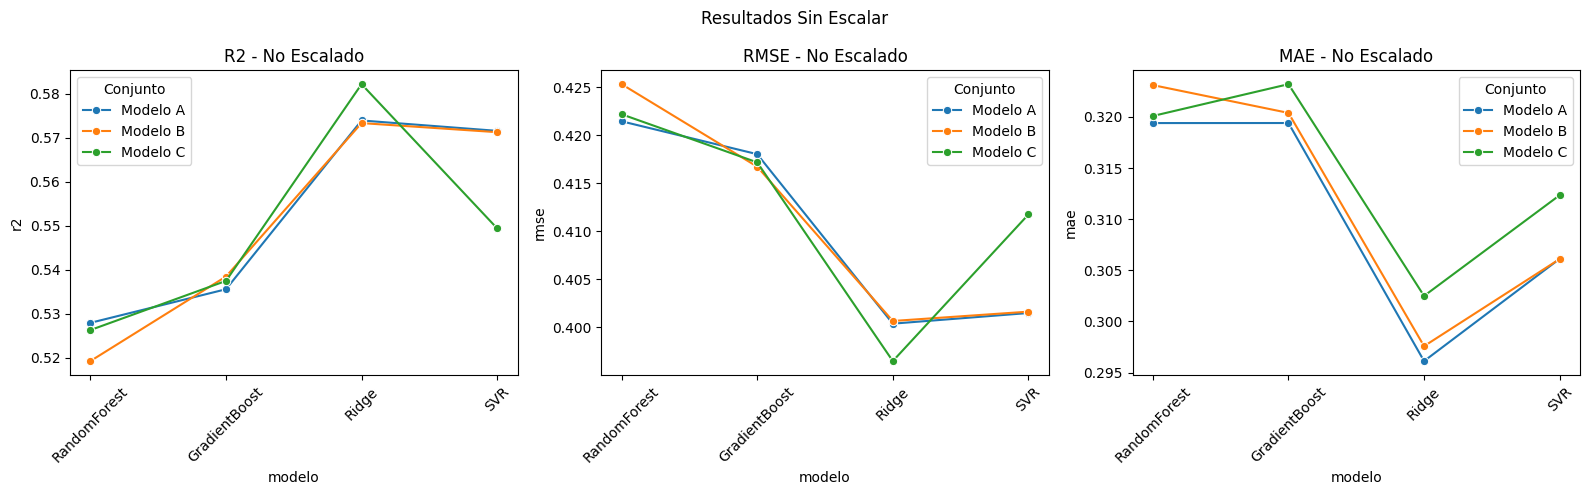

In [ ]:
graficar_agrupado_por_escalado(resultados_4mod_rmse_df_unido, 'No Escalado')

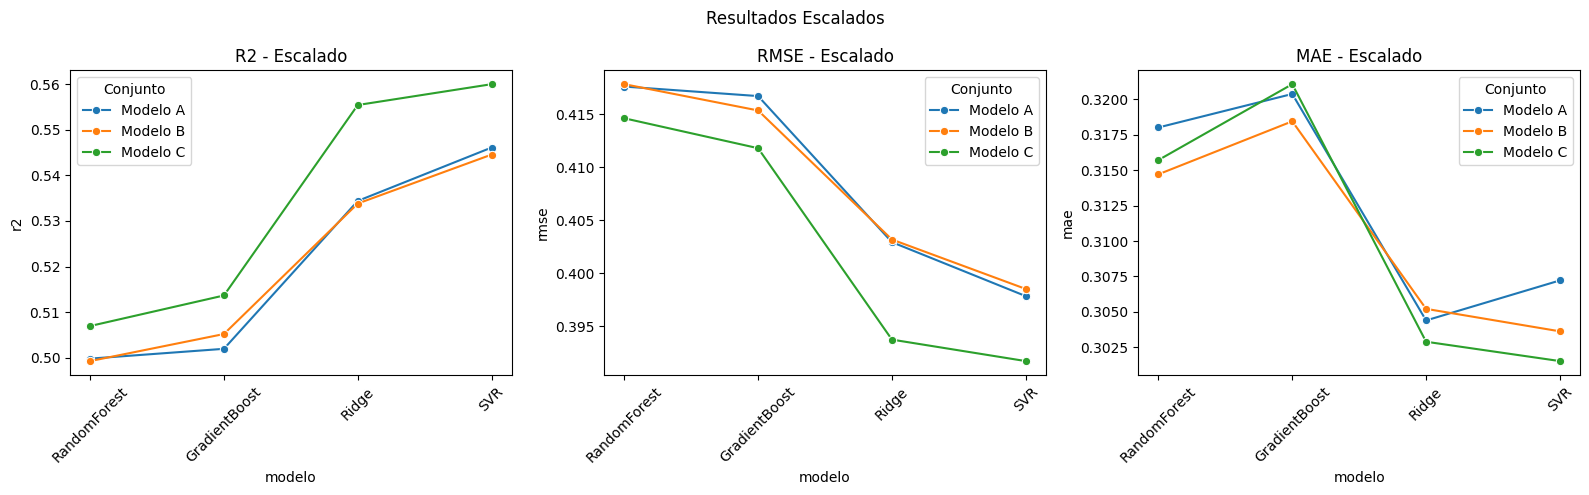

In [ ]:
graficar_agrupado_por_escalado(resultados_4mod_rmse_df_unido, 'Escalado')